In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

# understat import for understat api
import asyncio
import json
import aiohttp
from understat import Understat
year = ['2014','2015','2016','2017','2018','2019','2020']

import sys,importlib
# importlib.reload(sys.modules['function'])
from function import *

modèle regression logistique 
* résultat :
    * européen
    * non-européen

* Critère défense : 
    * valeur
    * taille
    * vitesse
    * expérience
    * (poid)

# Projet 8 - Arsenal, européen ?

Préparation des données

In [9]:
ligue_df_all = []
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        for i in year:
            table = await understat.get_league_table("Bundesliga", i)
            ligue_df = pd.DataFrame(data=table)
            ligue_df['year'] = i
            ligue_df['Rank'] = ligue_df.index
            ligue_df_all.append(ligue_df)
        df = pd.concat(ligue_df_all)
        return df
loop = asyncio.get_event_loop()
import nest_asyncio
nest_asyncio.apply()
df_ligue = loop.run_until_complete(main())
df_ligue.columns = df_ligue.iloc[0]
df_ligue = df_ligue[1:] 
df_ligue.rename(columns={'2014':'Years',0:'Rank'},inplace=True)
df_ligue = df_ligue[['Rank','Team','M','W','D','L','G','GA','PTS','xG','xGA','xPTS','Years']]

In [145]:
df_ligue['Team'].unique()

NameError: name 'df_ligue' is not defined

In [15]:
euro_crew = ['fc-bayern-munchen', 'vfl-wolfsburg', 'borussia-monchengladbach', 'bayer-04-leverkusen','fc-augsburg', 'fc-schalke-04', 'borussia-dortmund', 'tsg-1899-hoffenheim','eintracht-frankfurt','sv-werder-bremen',
             '1-fsv-mainz-05','1-fc-koln','hannover-96','vfb-stuttgart','hertha-bsc','hamburger-sv','sc-freiburg','sc-paderborn-07','fc-ingolstadt-04','sv-darmstadt-98',
             'rasenballsport-leipzig','fortuna-dusseldorf','1-fc-nurnberg','1-fc-union-berlin','arminia-bielefeld']
num = ['27','82','18','15','167','33','16','533','24','86','39','3','42','79','44','41','60','127','4795','105','23826','38','4','89','10']
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

In [16]:
for eq,num_eq in zip(euro_crew,num):
    print(eq,num_eq)

fc-bayern-munchen 27
vfl-wolfsburg 82
borussia-monchengladbach 18
bayer-04-leverkusen 15
fc-augsburg 167
fc-schalke-04 33
borussia-dortmund 16
tsg-1899-hoffenheim 533
eintracht-frankfurt 24
sv-werder-bremen 86
1-fsv-mainz-05 39
1-fc-koln 3
hannover-96 42
vfb-stuttgart 79
hertha-bsc 44
hamburger-sv 41
sc-freiburg 60
sc-paderborn-07 127
fc-ingolstadt-04 4795
sv-darmstadt-98 105
rasenballsport-leipzig 23826
fortuna-dusseldorf 38
1-fc-nurnberg 4
1-fc-union-berlin 89
arminia-bielefeld 10


In [19]:
header_crew = ['Position', 'Valeur maximum']
df_crew = []

for eq,num_eq in zip(euro_crew,num):
    for k in year:
        try:
            print(eq,k)
            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            value = soup.find('div',{'class':'large-8 columns'}).div.find('div',{'class':'responsive-table'}).table.tbody.find_all('tr')
            list_attribute = []
            list_money_money = []
            table_list = []
            for i in value:
                try:
                    money = i.find('td',{'class':'rechts hauptlink'}).text
                    if 'K' in money:
                        list_money_money.append(float(money.split(' ')[0])/1000)
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)
                    elif 'mio' in money:
                        list_money_money.append(float(money.split(' ')[0].replace(',','.')))
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)

                except AttributeError:
                    continue

            table_list.append(list_attribute)
            table_list.append(list_money_money)
            value_crew = pd.DataFrame(data=table_list,index=header_crew)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            value_crew = value_crew.T
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            value_crew = value_crew.reset_index()

            #print(value_crew)
            value_crew_max = value_crew.sort_values(by='Valeur maximum',ascending=False)
            gardien = value_crew_max[value_crew_max['Position'] == 'Gardien de but'].iloc[0:1]
            defenseur = value_crew_max[(value_crew_max['Position'] == 'Défenseur central')|(value_crew_max['Position'] == 'Arrière gauche')|(value_crew_max['Position'] == 'Arrière droit')].iloc[0:1]
            milieu = value_crew_max[(value_crew_max['Position'] == 'Milieu défensif')|(value_crew_max['Position'] == 'Milieu central')|(value_crew_max['Position'] == 'Milieu offensif')].iloc[0:1]
            attaquant = value_crew_max[(value_crew_max['Position'] == 'Ailier droit')|(value_crew_max['Position'] == 'Ailier gauche')|(value_crew_max['Position'] == 'Avant-centre')].iloc[0:1]
            total = value_crew_max.iloc[0:1]

            gardien['Position'] = 'Gardien'
            defenseur['Position'] = 'Défense'
            milieu['Position'] = 'Milieu'
            attaquant['Position'] = 'Attaquant'
            total['Position'] = 'Total'
            value_crew_all = pd.concat([gardien,defenseur,milieu,attaquant,total])
            df_crew.append(value_crew_all)
            
        except TimeoutError:
            print('k')
            print(eq,k)
            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            value = soup.find('div',{'class':'large-8 columns'}).div.find('div',{'class':'responsive-table'}).table.tbody.find_all('tr')
            list_attribute = []
            list_money_money = []
            table_list = []
            for i in value:
                try:
                    money = i.find('td',{'class':'rechts hauptlink'}).text
                    if 'K' in money:
                        list_money_money.append(float(money.split(' ')[0])/1000)
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)
                    elif 'mio' in money:
                        list_money_money.append(float(money.split(' ')[0].replace(',','.')))
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)

                except AttributeError:
                    continue

            table_list.append(list_attribute)
            table_list.append(list_money_money)
            value_crew = pd.DataFrame(data=table_list,index=header_crew)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            value_crew = value_crew.T
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            value_crew = value_crew.reset_index()

            #print(value_crew)
            value_crew_max = value_crew.sort_values(by='Valeur maximum',ascending=False)
            gardien = value_crew_max[value_crew_max['Position'] == 'Gardien de but'].iloc[0:1]
            defenseur = value_crew_max[(value_crew_max['Position'] == 'Défenseur central')|(value_crew_max['Position'] == 'Arrière gauche')|(value_crew_max['Position'] == 'Arrière droit')].iloc[0:1]
            milieu = value_crew_max[(value_crew_max['Position'] == 'Milieu défensif')|(value_crew_max['Position'] == 'Milieu central')|(value_crew_max['Position'] == 'Milieu offensif')].iloc[0:1]
            attaquant = value_crew_max[(value_crew_max['Position'] == 'Ailier droit')|(value_crew_max['Position'] == 'Ailier gauche')|(value_crew_max['Position'] == 'Avant-centre')].iloc[0:1]
            total = value_crew_max.iloc[0:1]

            gardien['Position'] = 'Gardien'
            defenseur['Position'] = 'Défense'
            milieu['Position'] = 'Milieu'
            attaquant['Position'] = 'Attaquant'
            total['Position'] = 'Total'
            value_crew_all = pd.concat([gardien,defenseur,milieu,attaquant,total])
            df_crew.append(value_crew_all)
            continue
df_value_max = pd.concat(df_crew)

fc-bayern-munchen 2014


<ipython-input-19-533fd743d504>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total['Position'] = 'Total'


fc-bayern-munchen 2015
fc-bayern-munchen 2016
fc-bayern-munchen 2017
fc-bayern-munchen 2018
fc-bayern-munchen 2019
fc-bayern-munchen 2020
vfl-wolfsburg 2014
vfl-wolfsburg 2015
vfl-wolfsburg 2016
vfl-wolfsburg 2017
vfl-wolfsburg 2018
vfl-wolfsburg 2019
vfl-wolfsburg 2020
borussia-monchengladbach 2014
borussia-monchengladbach 2015
borussia-monchengladbach 2016
borussia-monchengladbach 2017
borussia-monchengladbach 2018
borussia-monchengladbach 2019
borussia-monchengladbach 2020
bayer-04-leverkusen 2014
bayer-04-leverkusen 2015
bayer-04-leverkusen 2016
bayer-04-leverkusen 2017
bayer-04-leverkusen 2018
bayer-04-leverkusen 2019
bayer-04-leverkusen 2020
fc-augsburg 2014
fc-augsburg 2015
fc-augsburg 2016
fc-augsburg 2017
fc-augsburg 2018
fc-augsburg 2019
fc-augsburg 2020
fc-schalke-04 2014
fc-schalke-04 2015
fc-schalke-04 2016
fc-schalke-04 2017
fc-schalke-04 2018
fc-schalke-04 2019
fc-schalke-04 2020
borussia-dortmund 2014
borussia-dortmund 2015
borussia-dortmund 2016
borussia-dortmund 2017


In [20]:
df_crew = []
header_crew = ['Positions', 'Âge', 'Valeur marchande', 'Valeur marchande moyenne']
for eq,num_eq in zip(euro_crew,num):
    print(eq,num_eq)

    for k in year:

        page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
        pageTree = requests.get(page, headers=headers)
        soup = BeautifulSoup(pageTree.content, 'html.parser')
        body = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tbody.find_all('td')
        foot = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tfoot.find_all('tr')
        x = 0
        table_list = [header_crew]
        body_list = []
        for g in body:

            body_list.append(g.text)
            x = x + 1
            if x == 5:
                table_list.append(body_list[1:])
                body_list = []
                x = 0

        for h in foot: 
            foot_list = []
            for gk2 in h.find_all('td'):
                foot_list.append(gk2.text)
            table_list.append(foot_list)

        value_crew = pd.DataFrame(data=table_list)
        value_crew.columns = value_crew.iloc[0]
        value_crew = value_crew.iloc[1:]
        #print(value_crew,k)
        value_crew['Years'] = k
        value_crew['Crew'] = eq
        df_crew.append(value_crew)
#print(df_crew)
df_euro_all = pd.concat(df_crew)

fc-bayern-munchen 27
vfl-wolfsburg 82
borussia-monchengladbach 18
bayer-04-leverkusen 15
fc-augsburg 167
fc-schalke-04 33
borussia-dortmund 16
tsg-1899-hoffenheim 533
eintracht-frankfurt 24
sv-werder-bremen 86
1-fsv-mainz-05 39
1-fc-koln 3
hannover-96 42
vfb-stuttgart 79
hertha-bsc 44
hamburger-sv 41
sc-freiburg 60
sc-paderborn-07 127
fc-ingolstadt-04 4795
sv-darmstadt-98 105
rasenballsport-leipzig 23826
fortuna-dusseldorf 38
1-fc-nurnberg 4
1-fc-union-berlin 89
arminia-bielefeld 10


In [21]:
df_euro_all

,Positions,Âge,Valeur marchande,Valeur marchande moyenne,Years,Crew
1,Gardien,"26,20","49,75 mio. €","9,95 mio. €",2014,fc-bayern-munchen
2,Défense,"25,33","177,25 mio. €","19,69 mio. €",2014,fc-bayern-munchen
3,Milieu de terrain,"22,17","158,13 mio. €","13,18 mio. €",2014,fc-bayern-munchen
4,Attaquant,"26,29","190,00 mio. €","27,14 mio. €",2014,fc-bayern-munchen
5,Total:,"24,52","575,13 mio. €","17,43 mio. €",2014,fc-bayern-munchen
...,...,...,...,...,...,...
1,Gardien,"22,50","6,70 mio. €","1,68 mio. €",2020,arminia-bielefeld
2,Défense,"24,75","17,15 mio. €","2,14 mio. €",2020,arminia-bielefeld
3,Milieu de terrain,"22,27","19,20 mio. €","1,75 mio. €",2020,arminia-bielefeld
4,Attaquant,"25,50","13,68 mio. €","1,37 mio. €",2020,arminia-bielefeld


In [22]:
df_euro_all.rename(columns={'Valeur marchande':'Valeur marchande (millions)','Valeur marchande moyenne':'Valeur marchande moyenne (millions)'},inplace=True)

In [23]:
# df_euro_all[['Position', 'Valeur maximum', 'Valeur marchande (millions)','Valeur marchande moyenne (millions)', 'Years', 'Crew']]

In [24]:
df_euro_all = df_euro_all[df_euro_all['Valeur marchande (millions)'] != '-']

In [25]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande (millions)']]
df_euro_all['Valeur marchande moyenne (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande moyenne (millions)']]

In [26]:
for i in df_euro_all['Valeur marchande (millions)']:
    if ' mrd. €' in i:
        print(float(i.replace(' mrd. €','')))

In [27]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande (millions)']]

In [28]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(' mio. €','') for i in df_euro_all['Valeur marchande (millions)']]
df_euro_all['Valeur marchande moyenne (millions)'] = [i.replace(' mio. €','') for i in df_euro_all['Valeur marchande moyenne (millions)']]

In [29]:
list_vald = []
for i in df_euro_all['Valeur marchande (millions)']:
    if ' mrd. €' in i:
        list_vald.append(float(i.replace(' mrd. €',''))*1000)
    elif ' K €' in i:
        list_vald.append(float(i.replace(' K €',''))/1000)        
    else:
        list_vald.append(float(i))
    
df_euro_all['Valeur marchande (millions)'] = list_vald

In [30]:
list_vald = []
for i in df_euro_all['Valeur marchande moyenne (millions)']:
    if ' mrd. €' in i:
        list_vald.append(float(i.replace(' mrd. €',''))*1000)
    elif ' K €' in i:
        list_vald.append(float(i.replace(' K €',''))/1000)        
    else:
        list_vald.append(float(i))
    
df_euro_all['Valeur marchande moyenne (millions)'] = list_vald

In [31]:
df_euro_all['Positions'] = [i.replace(':','') for i in df_euro_all['Positions']]

In [32]:
df_euro_all['Crew'] = [i.replace('-',' ') for i in df_euro_all['Crew']]
df_euro_all['Crew'] = [i.replace('fc','') for i in df_euro_all['Crew']]

In [33]:
df_ligue = df_ligue[df_ligue['Team'] != 'Team']

In [49]:
df_ligue.to_csv('ligue_Bun.csv',index=False)
df_value_max.to_csv('all_value_max_Bun.csv',index=False)

In [35]:
df_euro_all.to_csv('all_value_euro_Bun.csv',index=False)

In [36]:
ligue_player_all = []
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        for i in year:
            table = await understat.get_league_players("Bundesliga", i)
            ligue_player = pd.DataFrame(data=table)
            ligue_player['year'] = i
            ligue_player_all.append(ligue_player)
        df = pd.concat(ligue_player_all)
        return df
loop = asyncio.get_event_loop()

In [37]:
import nest_asyncio
nest_asyncio.apply()
df_ligue_player = loop.run_until_complete(main())

In [38]:
df_ligue_player.head()

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup,year
0,356,Alexander Meier,26,2209,19,15.395941108465195,2,1.2686937591060996,80,22,0,0,F M S,Eintracht Frankfurt,16,12.36483433842659,12.408789467066526,1.9156581219285727,2014
1,227,Robert Lewandowski,31,2493,17,17.722183350473642,5,4.644012805074453,104,32,0,0,F M S,Bayern Munich,16,16.96440664306283,23.31542954593897,4.924822298809886,2014
2,392,Arjen Robben,21,1681,17,10.364112377166748,7,7.5059698559343815,88,50,0,0,D F M S,Bayern Munich,15,8.848720371723175,20.820983182638884,8.605793077498674,2014
3,158,Bas Dost,21,1532,16,11.341977171599865,4,2.659186452627182,43,15,1,0,F S,Wolfsburg,16,11.341977171599865,15.911891400814056,2.5383058693259954,2014
4,318,Pierre-Emerick Aubameyang,33,2724,16,15.39676003716886,6,6.378020296804607,102,46,4,0,F M S,Borussia Dortmund,14,13.881206726655364,20.852728059515357,2.5126496041193604,2014


In [39]:
# print(df_ligue_player.dtypes)
# df_ligue_player.columns

In [40]:
df_ligue_player['xG'] = [np.around(float(i),decimals=4) for i in df_ligue_player['xG']]
df_ligue_player['xA'] = [np.around(float(i),decimals=4) for i in df_ligue_player['xA']]


In [41]:
column = ['games', 'time', 'goals',  'assists', 
       'shots', 'key_passes', 'yellow_cards', 'red_cards','npg', 'year']
for i in column:
    df_ligue_player[i] = df_ligue_player[i].astype(int)

In [42]:
column = ['xG','xA','npxG', 'xGChain', 'xGBuildup']
for i in column:
    df_ligue_player[i] = [np.around(float(i),decimals=4) for i in df_ligue_player[i]]
    

In [43]:
# df_ligue_player[df_ligue_player['team_title'] == 'Montpellier']

In [44]:
df_ligue_player.to_csv('all_player_Bun.csv',index=False)

# Analyse

In [15]:
df_player = pd.read_csv('all_player_Bun.csv',sep=',')
df_euro = pd.read_csv('all_value_euro_Bun.csv',sep=',')
value_max = pd.read_csv('all_value_max_Bun.csv',sep=',')

In [16]:
ligue = pd.read_csv('ligue_Bun.csv',sep=',')

In [52]:
# column_2019 = ligue.columns
# psg_2019 = []
# for i in column_2019:
#     if (i == 'Rank')|(i == 'Team')|(i == 'Years'):
#         psg_2019.append(ligue[(ligue['Years'] == 2019)&((ligue['Team'] == 'Paris Saint Germain')|(ligue['Team'] == 'Strasbourg'))][i])
#     else:
#         psg_2019.append(ligue[(ligue['Years'] == 2019)&((ligue['Team'] == 'Paris Saint Germain')|(ligue['Team'] == 'Strasbourg'))][i]*1.4074074074074074)

# psg_2019_df = pd.DataFrame(data=psg_2019)
# psg_2019_df = psg_2019_df.T

In [53]:
# euro_2019 = []
# for i in column_2019:
#     if (i == 'Rank')|(i == 'Team')|(i == 'Years'):
#         euro_2019.append(pd.concat([ligue[ligue['Years'] == 2019].iloc[1:10][i],ligue[ligue['Years'] == 2019].iloc[11:][i]]))
#     else:
#         euro_2019.append(pd.concat([ligue[ligue['Years'] == 2019].iloc[1:10][i]*1.3571428571428572,ligue[ligue['Years'] == 2019].iloc[11:][i]*1.3571428571428572]))
# euro_2019_df = pd.DataFrame(data=euro_2019)
# euro_2019_df = euro_2019_df.T

In [54]:
# euro_ligue_without = ligue[ligue['Years'] != 2019]
ligue_corr = ligue
# ligue_corr = ligue_corr.sort_index()

In [55]:
list_xG = []
for i,a in zip(list(ligue['xG']),list(ligue['G'])):
    #print(i,a)
    list_xG.append(np.around(int(a)/int(i),decimals=3))

list_xGA = []
for e,h in zip(list(ligue['xGA']),list(ligue['GA'])):
    list_xGA.append(np.around(int(h)/int(e),decimals=3))

list_xPTS = []
for e,h in zip(list(ligue['xPTS']),list(ligue['PTS'])):
    list_xPTS.append(np.around(int(h)/int(e),decimals=3))

ligue_corr['xG coef'] = list_xG
ligue_corr['xGA coef'] = list_xGA
ligue_corr['xPTS coef'] = list_xPTS

In [56]:
ligue_corr['M'] = [np.around(i,decimals=0) for i in ligue_corr['M']]
ligue_corr['W'] = [np.around(i,decimals=0) for i in ligue_corr['W']]
ligue_corr['D'] = [np.around(i,decimals=0) for i in ligue_corr['D']]
ligue_corr['L'] = [np.around(i,decimals=0) for i in ligue_corr['L']]
ligue_corr['G'] = [np.around(i,decimals=3) for i in ligue_corr['G']]
ligue_corr['GA'] = [np.around(i,decimals=3) for i in ligue_corr['GA']]
ligue_corr['PTS'] = [np.around(i,decimals=0) for i in ligue_corr['PTS']]
ligue_corr['xG'] = [np.around(i,decimals=3) for i in ligue_corr['xG']]
ligue_corr['xGA'] = [np.around(i,decimals=3) for i in ligue_corr['xGA']]
ligue_corr['xPTS'] = [np.around(i,decimals=3) for i in ligue_corr['xPTS']]
ligue_corr['xG coef'] = [np.around(i,decimals=3) for i in ligue_corr['xG coef']]
ligue_corr['xGA coef'] = [np.around(i,decimals=3) for i in ligue_corr['xGA coef']]

In [64]:
ligue_corr.to_csv('ligue_corrected_Bun.csv',index=False)

In [2]:
ligue_corr = pd.read_csv('ligue_corrected_Bun.csv',sep=',')

In [3]:
ligue_corr[ligue_corr['Years'] == 2014]

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef
0,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082
1,2,Wolfsburg,34,20,9,5,72,38,69,58.35,38.82,59.95,2014,1.241,1.000,1.169
2,3,Borussia M.Gladbach,34,19,9,6,53,26,66,51.74,36.34,57.01,2014,1.039,0.722,1.158
3,4,Bayer Leverkusen,34,17,10,7,62,37,61,49.16,34.72,55.34,2014,1.265,1.088,1.109
4,5,Augsburg,34,15,4,15,43,43,49,43.91,46.66,45.50,2014,1.000,0.935,1.089
5,6,Schalke 04,34,13,9,12,42,40,48,41.26,46.96,45.07,2014,1.024,0.870,1.067
6,7,Borussia Dortmund,34,13,7,14,47,42,46,53.86,33.40,58.08,2014,0.887,1.273,0.793
7,8,Hoffenheim,34,12,8,14,49,55,44,49.96,50.00,46.03,2014,1.000,1.100,0.957
8,9,Eintracht Frankfurt,34,11,10,13,56,62,43,47.37,55.04,41.72,2014,1.191,1.127,1.049
9,10,Werder Bremen,34,11,10,13,50,65,43,42.67,52.38,39.38,2014,1.190,1.250,1.103


In [4]:
ars = ligue_corr[ligue_corr['Team'] == 'Borussia M.Gladbach']

In [5]:
column = ['M', 'W', 'D', 'L', 'G', 'GA', 'PTS','Years']
for i in column:
    ars[i] = ars[i].astype(int)
    ligue_corr[i] = ligue_corr[i].astype(int)

<ipython-input-5-d197d87a3f85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ars[i] = ars[i].astype(int)


In [6]:
ligue_corr['Team'].unique()

array(['Bayern Munich', 'Wolfsburg', 'Borussia M.Gladbach',
       'Bayer Leverkusen', 'Augsburg', 'Schalke 04', 'Borussia Dortmund',
       'Hoffenheim', 'Eintracht Frankfurt', 'Werder Bremen', 'Mainz 05',
       'FC Cologne', 'Hannover 96', 'VfB Stuttgart', 'Hertha Berlin',
       'Hamburger SV', 'Freiburg', 'Paderborn', 'Ingolstadt', 'Darmstadt',
       'RasenBallsport Leipzig', 'Fortuna Duesseldorf', 'Nuernberg',
       'Union Berlin', 'Arminia Bielefeld'], dtype=object)

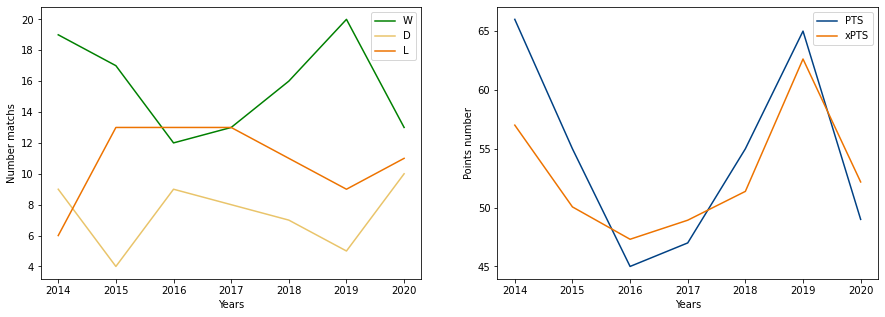

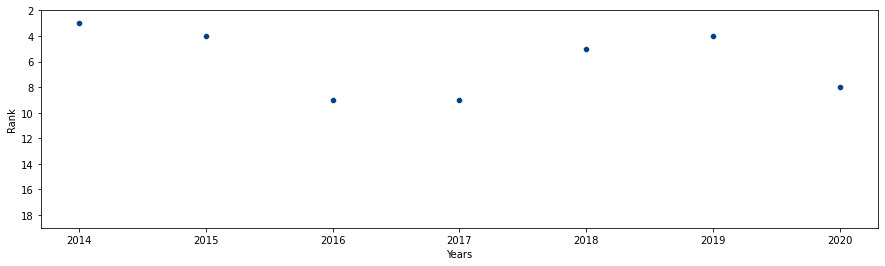

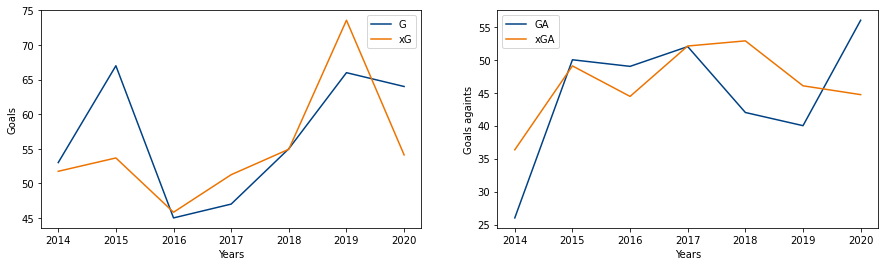

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=[15,5])
# plt.plot(list(ars['Years']), list(ars['L']), label='L')
plt.subplot(121)
sns.lineplot(x="Years",y='W',data=ars,color='green',label='W')
sns.lineplot(x="Years",y='D',data=ars,color='#e9c46a',label='D')
sns.lineplot(x="Years",y='L',data=ars,color='#ED7300',label='L')
plt.ylabel('Number matchs')
plt.subplot(122)
sns.lineplot(x="Years",y='PTS',data=ars,color='#004184',label='PTS')
sns.lineplot(x="Years",y='xPTS',data=ars,color='#ED7300',label='xPTS')
plt.ylabel('Points number')
plt.show()
plt.figure(figsize=[15,4])
sns.scatterplot(x="Years",y='Rank',data=ars,color='#004184')
plt.ylim(19,2)
# for index,row in zip(range(0,len(ars.index)),ars['Rank']):
#     print(row)
#     plt.text(index*0.1,,str(row), color='black', ha="center")
plt.show()
plt.figure(figsize=[15,4])
plt.subplot(121)
sns.lineplot(x="Years",y='G',data=ars,color='#004184',label='G')
sns.lineplot(x="Years",y='xG',data=ars,color='#ED7300',label='xG')
plt.ylabel('Goals')
plt.subplot(122)
sns.lineplot(x="Years",y='GA',data=ars,color='#004184',label='GA')
sns.lineplot(x="Years",y='xGA',data=ars,color='#ED7300',label='xGA')
plt.ylabel('Goals againts')
plt.show()

### Player

In [8]:
euro_ligue_corr = ligue_corr[ligue_corr['Rank'] < 7]

In [9]:
euro_ligue_corr['Team'].unique()

array(['Bayern Munich', 'Wolfsburg', 'Borussia M.Gladbach',
       'Bayer Leverkusen', 'Augsburg', 'Schalke 04', 'Borussia Dortmund',
       'Mainz 05', 'RasenBallsport Leipzig', 'Hoffenheim', 'FC Cologne',
       'Hertha Berlin', 'Eintracht Frankfurt'], dtype=object)

In [17]:
df_ars_players_stat = []
for i in year:
    goals = sum(df_player[(df_player['team_title'] == 'Borussia M.Gladbach')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['goals'])    
    expect_goals = sum(df_player[(df_player['team_title'] == 'Borussia M.Gladbach')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['xG'])
    np = sum(df_player[(df_player['team_title'] == 'Borussia M.Gladbach')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['npg'])    
    npG = sum(df_player[(df_player['team_title'] == 'Borussia M.Gladbach')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['npxG'])
    red_card = sum(df_player[(df_player['team_title'] == 'Borussia M.Gladbach')&(df_player['year'] == int(i))]['red_cards'])
    yellow_card = sum(df_player[(df_player['team_title'] == 'Borussia M.Gladbach')&(df_player['year'] == int(i))]['yellow_cards'])
    df_ars_players_stat.append(pd.DataFrame({'year':[i],'goals':[goals],'expect_goals':[expect_goals],'goals without penalty':[np],'expect goals without penalty':[npG],'red card':[red_card],'yellow card':[yellow_card]}))
stat_ars = pd.concat(df_ars_players_stat)

In [18]:
import numpy as np

In [19]:
list_goal_pourcent = []
for i,e in zip(stat_ars['goals'],ars['G']):
    #print(e,i)
    list_goal_pourcent.append(np.around(((i/e)*100),decimals=3))

In [20]:
stat_ars['Pourcent goal'] = list_goal_pourcent

A faire :

    - pourcentage de goals des 3 meilleurs buteurs sur l'ensemble des buts
    - red/yellow card 
 

In [21]:
stat_ars

,year,goals,expect_goals,goals without penalty,expect goals without penalty,red card,yellow card,Pourcent goal
0,2014,34,31.3539,31,29.0806,2,54,64.151
0,2015,28,23.8539,26,21.5805,3,45,41.791
0,2016,24,21.2969,23,19.0236,2,45,53.333
0,2017,25,27.9115,19,22.6072,0,47,53.191
0,2018,27,26.7029,23,21.3984,0,43,49.091
0,2019,29,31.4298,27,29.1565,3,71,43.939
0,2020,28,21.3149,19,13.7374,2,61,43.750


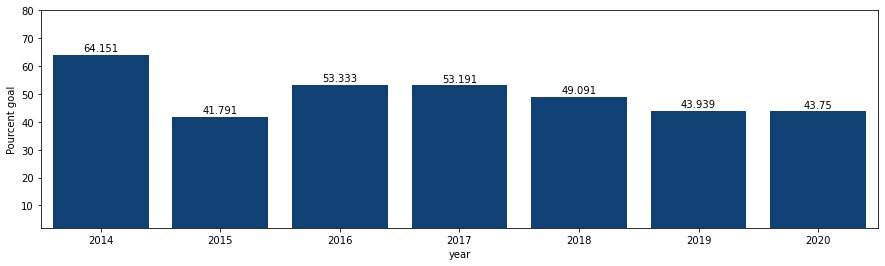

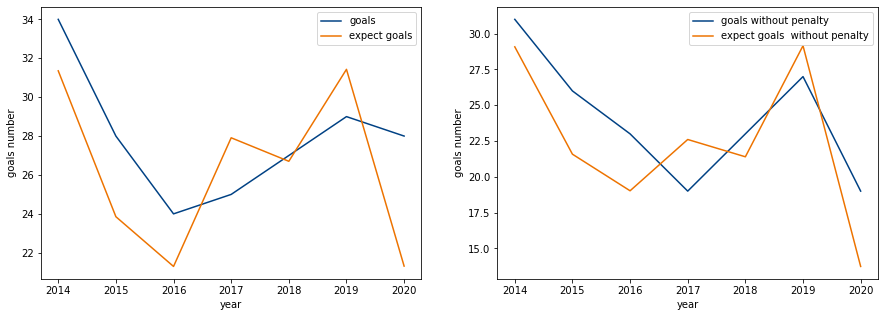

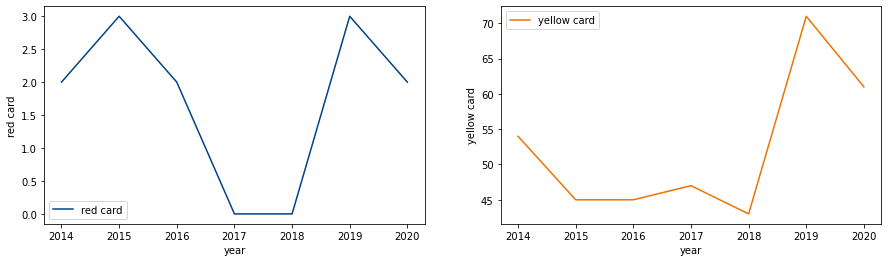

In [22]:
plt.figure(figsize=[15,4])
sns.barplot(x="year",y='Pourcent goal',data=stat_ars,color='#004184')
rects = stat_ars["year"]
labels = stat_ars['Pourcent goal']
for rect, label in zip(range(0,(len(rects))), labels):
    height = label
    plt.text(
        rect, height + 0.5, label, ha="center", va="bottom"
    )
plt.ylim(2,80)
plt.show()
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.lineplot(x="year",y='goals',data=stat_ars,color='#004184',label='goals')
sns.lineplot(x="year",y='expect_goals',data=stat_ars,color='#ED7300',label='expect goals')
plt.ylabel('goals number')
plt.subplot(122)
sns.lineplot(x="year",y='goals without penalty',data=stat_ars,color='#004184',label='goals without penalty')
sns.lineplot(x="year",y='expect goals without penalty',data=stat_ars,color='#ED7300',label='expect goals  without penalty')
plt.ylabel('goals number')
plt.show()
plt.figure(figsize=[15,4])
plt.subplot(121)
sns.lineplot(x="year",y='red card',data=stat_ars,color='#004184',label='red card')
plt.subplot(122)
sns.lineplot(x="year",y='yellow card',data=stat_ars,color='#ED7300',label='yellow card')
plt.show()

# Concurrents

In [23]:
ars

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef
2,3,Borussia M.Gladbach,34,19,9,6,53,26,66,51.74,36.34,57.01,2014,1.039,0.722,1.158
21,4,Borussia M.Gladbach,34,17,4,13,67,50,55,53.67,49.07,50.06,2015,1.264,1.020,1.100
44,9,Borussia M.Gladbach,34,12,9,13,45,49,45,45.82,44.44,47.31,2016,1.000,1.114,0.957
62,9,Borussia M.Gladbach,34,13,8,13,47,52,47,51.25,52.09,48.93,2017,0.922,1.000,0.979
76,5,Borussia M.Gladbach,34,16,7,11,55,42,55,54.93,52.87,51.38,2018,1.019,0.808,1.078
93,4,Borussia M.Gladbach,34,20,5,9,66,40,65,73.58,46.05,62.63,2019,0.904,0.870,1.048
115,8,Borussia M.Gladbach,34,13,10,11,64,56,49,54.11,44.71,52.18,2020,1.185,1.273,0.942


In [24]:
euro_ligue_corr = ligue_corr[ligue_corr['Rank'] < 7]

In [25]:
# ligue_corr[ligue_corr['Years'] == 2019]

In [26]:
ars_point= ars.set_index('Years')[['PTS','Rank']].T

In [27]:
list(ars_point.values[0])

[66, 55, 45, 47, 55, 65, 49]

In [28]:
# euro_ligue_corr

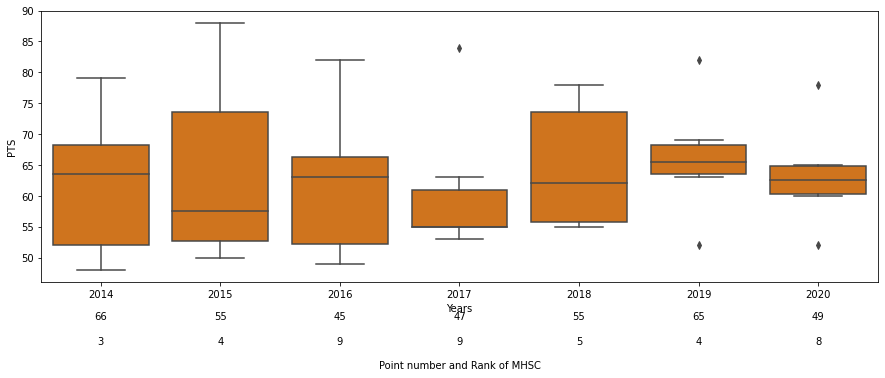

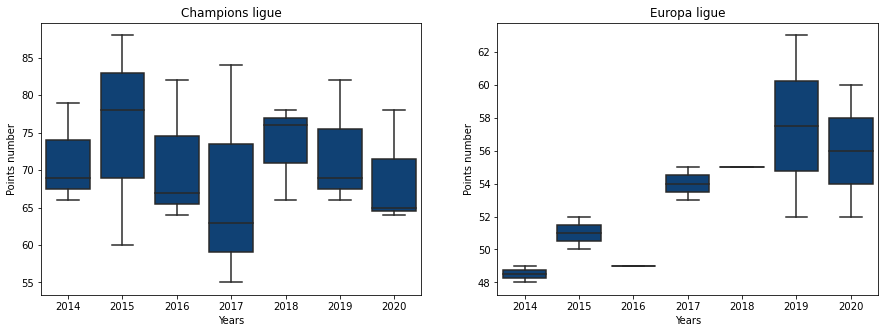

In [29]:
plt.figure(figsize=[15,5])
sns.boxplot(x='Years',y='PTS',data=euro_ligue_corr,color='#ED7300')  
rects = year
labels_point = list(ars_point.values[0])
labels_rank = list(ars_point.values[1])
plt.text(3,32,'Point number and Rank of MHSC',horizontalalignment='center')
for rect, label1,label2 in zip(range(0,(len(rects))), labels_point,labels_rank):
    height = label
    plt.text(rect, 40, label1,horizontalalignment='center')
    plt.text(rect, 36, label2,horizontalalignment='center')
plt.show()
# print()[].T)
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.boxplot(x="Years",y='PTS',data=euro_ligue_corr[euro_ligue_corr['Rank'] < 4],color='#004184')
plt.ylabel('Points number')
plt.title('Champions ligue')
plt.subplot(122)
sns.boxplot(x="Years",y='PTS',data=euro_ligue_corr[(euro_ligue_corr['Rank'] > 4)&(euro_ligue_corr['Rank'] < 8)],color='#004184')
plt.ylabel('Points number')
plt.title('Europa ligue')
plt.show()

# Expected points 

In [30]:
ars_expect_point = ars.set_index('Years')[['xPTS coef','Rank']].T

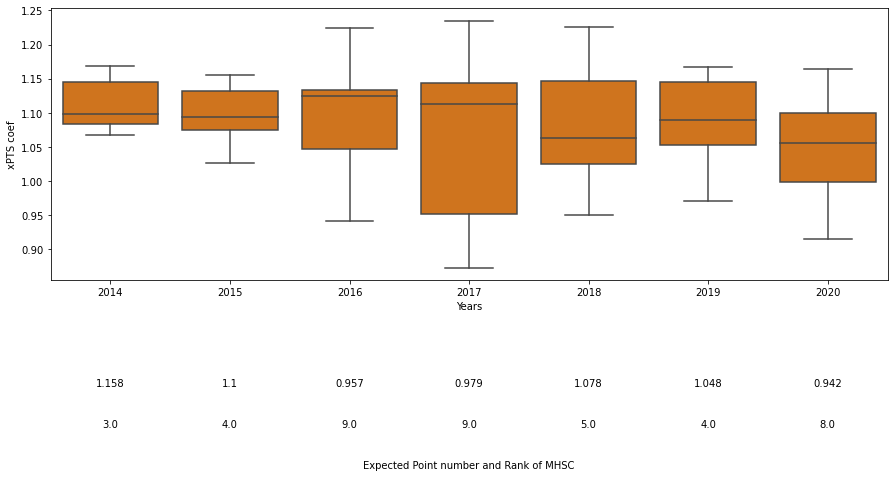

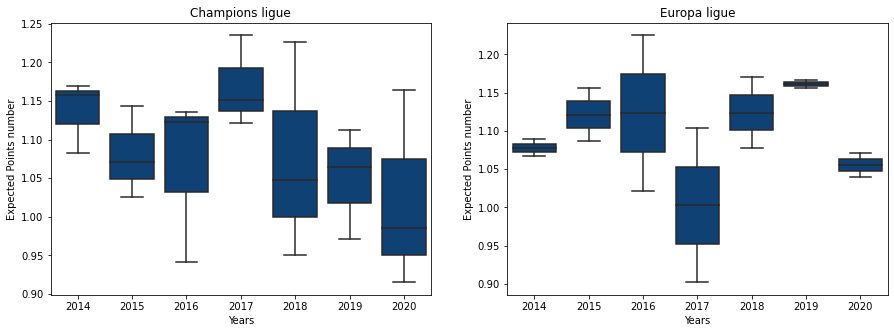

In [31]:
plt.figure(figsize=[15,5])
sns.boxplot(x='Years',y='xPTS coef',data=euro_ligue_corr,color='#ED7300')  
rects = year
labels_point = list(ars_expect_point.values[0])
labels_rank = list(ars_expect_point.values[1])
plt.text(3,0.58,'Expected Point number and Rank of MHSC',horizontalalignment='center')
for rect, label1,label2 in zip(range(0,(len(rects))), labels_point,labels_rank):
    height = label
    plt.text(rect, 0.7, label1,horizontalalignment='center')
    plt.text(rect, 0.64, label2,horizontalalignment='center')
plt.show()
# print()[].T)
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.boxplot(x="Years",y='xPTS coef',data=euro_ligue_corr[euro_ligue_corr['Rank'] < 4],color='#004184')
plt.ylabel('Expected Points number')
plt.title('Champions ligue')
plt.subplot(122)
sns.boxplot(x="Years",y='xPTS coef',data=euro_ligue_corr[(euro_ligue_corr['Rank'] > 4)&(euro_ligue_corr['Rank'] < 8)],color='#004184')
plt.ylabel('Expected Points number')
plt.title('Europa ligue')
plt.show()

# Valeurs marchandes

In [32]:
df_euro

,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions),Years,Crew
0,Gardien,"26,20",49.75,9.95,2014,bayern munchen
1,Défense,"25,33",177.25,19.69,2014,bayern munchen
2,Milieu de terrain,"22,17",158.13,13.18,2014,bayern munchen
3,Attaquant,"26,29",190.00,27.14,2014,bayern munchen
4,Total,"24,52",575.13,17.43,2014,bayern munchen
...,...,...,...,...,...,...
870,Gardien,"22,50",6.70,1.68,2020,arminia bielefeld
871,Défense,"24,75",17.15,2.14,2020,arminia bielefeld
872,Milieu de terrain,"22,27",19.20,1.75,2020,arminia bielefeld
873,Attaquant,"25,50",13.68,1.37,2020,arminia bielefeld


In [33]:
# for e,a,u in zip(df_euro['Valeur marchande (millions)'],df_euro['Crew'],df_euro['Positions']):
#     if 'K' in e:
#         print(e,a,u)

In [34]:
df_euro.dropna(axis=0,inplace=True)

In [35]:
# df_value_1 = []
# df_value_2 = []
# for i,e in zip(df_euro['Valeur marchande (millions)'],df_euro['Valeur marchande moyenne (millions)']):
#     if ('K' in e)&('K' in i):
#         df_value_1.append(float(i.split(' ')[0])/1000)
#         df_value_2.append(float(e.split(' ')[0])/1000)
#     elif 'K' in e:
#         df_value_1.append(float(i.replace(',','.')))
#         df_value_2.append(float(e.split(' ')[0])/1000)
#     elif 'K' in i:
#         df_value_1.append(float(i.split(' ')[0])/1000)
#         df_value_2.append(float(e.replace(',','.')))
#     else:
#         df_value_1.append(i.replace(',','.'))
#         df_value_2.append(i.replace(',','.'))

In [36]:
# df_euro['Valeur marchande (millions)'] = df_value_1
# df_euro['Valeur marchande moyenne (millions)'] = df_value_2

In [37]:
df_euro['Âge'] = [i.replace(',','.') for i in df_euro['Âge']] 
# df_euro['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro['Valeur marchande (millions)']] 
# df_euro['Valeur marchande moyenne (millions)'] = [i.replace(',','.') for i in df_euro['Valeur marchande moyenne (millions)']] 
# df_euro['Valeur marchande moyenne (millions)'] = [i.split(' ')[0] for i in df_euro['Valeur marchande moyenne (millions)']] 
# df_euro['Valeur marchande (millions)'] = [i.split(' ')[0] for i in df_euro['Valeur marchande (millions)']] 

In [38]:
column = ['Âge', 'Valeur marchande (millions)',
       'Valeur marchande moyenne (millions)']
for i in column:
    df_euro[i] = df_euro[i].astype(float)

In [39]:
ars_max = value_max[value_max['Crew'] == 'borussia-monchengladbach']

In [40]:
total = df_euro[(df_euro['Crew'] == 'borussia-monchengladbach')&(df_euro['Positions'] == 'Total')]

In [41]:
# print(df_euro['Crew'].unique())
# print(euro_ligue_corr['Team'].unique())

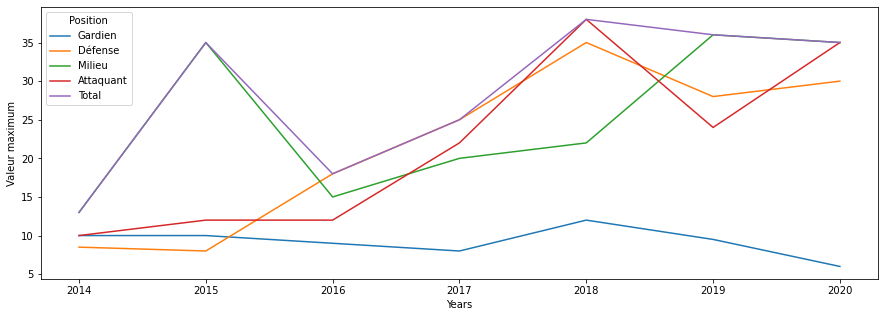

In [42]:
plt.figure(figsize=[15,5])
sns.lineplot(x='Years',y='Valeur maximum',hue='Position',data=ars_max)
plt.show()

In [43]:
# ligue_corr['Team'].unique()

In [44]:
# list(df_euro['Team'].unique()[10:])

In [45]:
print(ligue_corr['Team'].unique())
print(df_euro['Crew'].unique())

['Bayern Munich' 'Wolfsburg' 'Borussia M.Gladbach' 'Bayer Leverkusen'
 'Augsburg' 'Schalke 04' 'Borussia Dortmund' 'Hoffenheim'
 'Eintracht Frankfurt' 'Werder Bremen' 'Mainz 05' 'FC Cologne'
 'Hannover 96' 'VfB Stuttgart' 'Hertha Berlin' 'Hamburger SV' 'Freiburg'
 'Paderborn' 'Ingolstadt' 'Darmstadt' 'RasenBallsport Leipzig'
 'Fortuna Duesseldorf' 'Nuernberg' 'Union Berlin' 'Arminia Bielefeld']
[' bayern munchen' 'vfl wolfsburg' 'borussia monchengladbach'
 'bayer 04 leverkusen' ' augsburg' ' schalke 04' 'borussia dortmund'
 'tsg 1899 hoffenheim' 'eintracht frankfurt' 'sv werder bremen'
 '1 fsv mainz 05' '1  koln' 'hannover 96' 'vfb stuttgart' 'hertha bsc'
 'hamburger sv' 'sc freiburg' 'sc paderborn 07' ' ingolstadt 04'
 'sv darmstadt 98' 'rasenballsport leipzig' 'fortuna dusseldorf'
 '1  nurnberg' '1  union berlin' 'arminia bielefeld']


In [46]:
df_euro['Crew'] = [i.replace(' bayern munchen','Bayern Munich') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('vfl wolfsburg','Wolfsburg') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('borussia monchengladbach','Borussia M.Gladbach') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('bayer 04 leverkusen','Bayer Leverkusen') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' augsburg','Augsburg') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' schalke 04','Schalke 04') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('borussia dortmund','Borussia Dortmund') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('tsg 1899 hoffenheim','Hoffenheim') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('eintracht frankfurt','Eintracht Frankfurt') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('sv werder bremen','Werder Bremen') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('1 fsv mainz 05','Mainz 05') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('1  koln','FC Cologne') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('hannover 96','Hannover 96') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('vfb stuttgart','VfB Stuttgart') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('hertha bsc','Hertha Berlin') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('hamburger sv','Hamburger SV') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('sc freiburg','Freiburg') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('sc paderborn 07','Paderborn') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' ingolstadt 04','Ingolstadt') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('sv darmstadt 98','Darmstadt') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('rasenballsport leipzig','RasenBallsport Leipzig') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('fortuna dusseldorf','Fortuna Duesseldorf') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('1  nurnberg','Nuernberg') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('1  union berlin','Union Berlin') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('arminia bielefeld','Arminia Bielefeld') for i in df_euro['Crew']]


df_euro.rename(columns={'Crew':'Team'},inplace=True)

In [47]:
df_lig_val = ligue_corr.merge(df_euro,how='inner',on=['Team','Years'])

In [48]:
df_lig_val

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
0,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Gardien,26.20,49.75,9.95
1,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Défense,25.33,177.25,19.69
2,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Milieu de terrain,22.17,158.13,13.18
3,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Attaquant,26.29,190.00,27.14
4,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Total,24.52,575.13,17.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,18,Schalke 04,34,3,7,24,25,86,16,27.66,70.66,20.47,2020,0.926,1.229,0.800,Gardien,27.40,5.45,1.09
626,18,Schalke 04,34,3,7,24,25,86,16,27.66,70.66,20.47,2020,0.926,1.229,0.800,Défense,23.29,54.30,3.88
627,18,Schalke 04,34,3,7,24,25,86,16,27.66,70.66,20.47,2020,0.926,1.229,0.800,Milieu de terrain,22.19,39.10,2.44
628,18,Schalke 04,34,3,7,24,25,86,16,27.66,70.66,20.47,2020,0.926,1.229,0.800,Attaquant,25.50,24.20,2.42


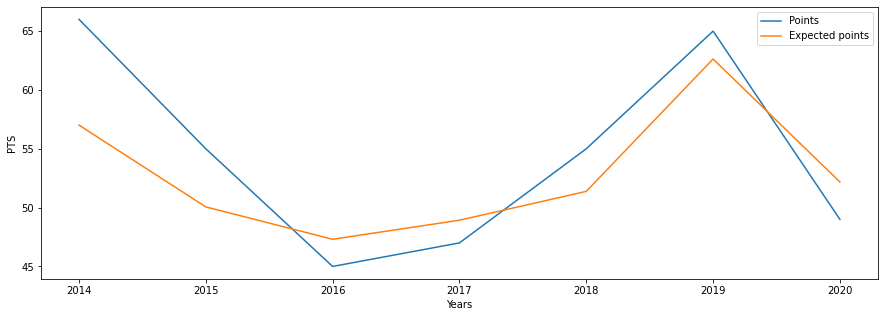

In [49]:
plt.figure(figsize=[15,5])
sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
sns.lineplot(x='Years',y='PTS',data=ars,label='Points')
sns.lineplot(x='Years',y='xPTS',data=ars,label='Expected points')
# rects = year
# labels_rank = list(ars['Rank'])
# plt.text(3,0.32,'Point number and Rank of MHSC',horizontalalignment='center')
# for rect, label in zip(range(0,len(rects)), labels_rank):
#     plt.text(rect, 0.36, label,horizontalalignment='center')
plt.show()

### Corrélation valeurs marchande / résultats 

In [50]:
df_lig_val

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
0,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Gardien,26.20,49.75,9.95
1,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Défense,25.33,177.25,19.69
2,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Milieu de terrain,22.17,158.13,13.18
3,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Attaquant,26.29,190.00,27.14
4,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Total,24.52,575.13,17.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,18,Schalke 04,34,3,7,24,25,86,16,27.66,70.66,20.47,2020,0.926,1.229,0.800,Gardien,27.40,5.45,1.09
626,18,Schalke 04,34,3,7,24,25,86,16,27.66,70.66,20.47,2020,0.926,1.229,0.800,Défense,23.29,54.30,3.88
627,18,Schalke 04,34,3,7,24,25,86,16,27.66,70.66,20.47,2020,0.926,1.229,0.800,Milieu de terrain,22.19,39.10,2.44
628,18,Schalke 04,34,3,7,24,25,86,16,27.66,70.66,20.47,2020,0.926,1.229,0.800,Attaquant,25.50,24.20,2.42


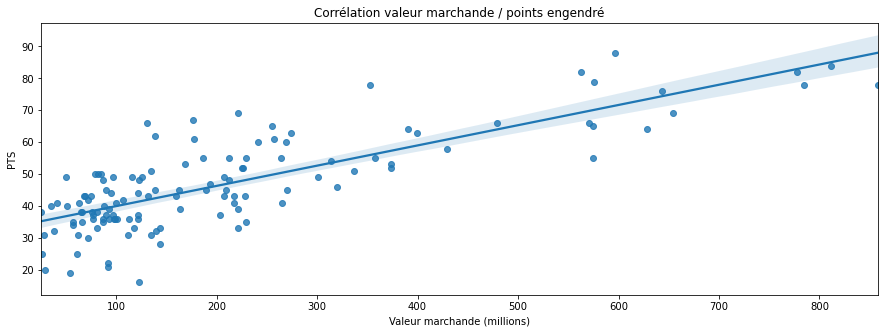

Covariance empirique :  2135.534559082892
Coefficient de Pearson :  0.7924346568309291

Les valeurs suivent une distribution linéaire


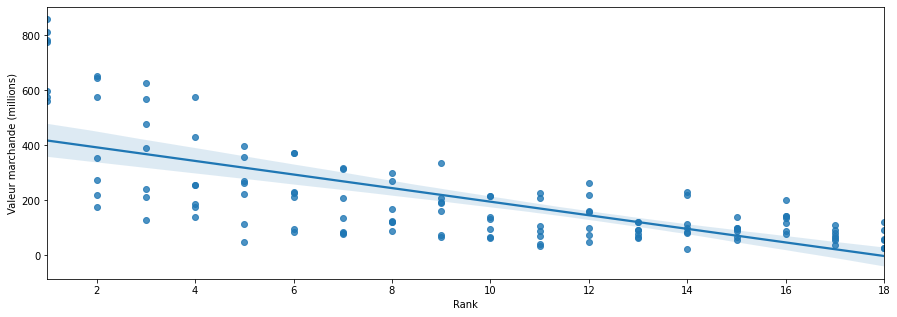

Covariance empirique :  -664.7536507936508
Coefficient de Pearson :  -0.6983298499815807

Les valeurs suivent une distribution linéaire


In [53]:
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='PTS',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.title('Corrélation valeur marchande / points engendré')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Total']["PTS"])
plt.figure(figsize=[15,5])
sns.regplot(x='Rank',y='Valeur marchande (millions)',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']['Rank'],df_lig_val[df_lig_val['Positions'] == 'Total']['Valeur marchande (millions)'])


### Corrélation valeurs marchande / buts marqués - encaissés

In [54]:
df_lig_val[(df_lig_val['G'] > 50)&(df_lig_val['Positions'] == 'Attaquant')]

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
3,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Attaquant,26.29,190.00,27.14
8,2,Wolfsburg,34,20,9,5,72,38,69,58.35,38.82,59.95,2014,1.241,1.000,1.169,Attaquant,26.80,47.00,9.40
13,3,Borussia M.Gladbach,34,19,9,6,53,26,66,51.74,36.34,57.01,2014,1.039,0.722,1.158,Attaquant,24.38,61.00,7.63
18,4,Bayer Leverkusen,34,17,10,7,62,37,61,49.16,34.72,55.34,2014,1.265,1.088,1.109,Attaquant,24.20,43.50,8.70
43,9,Eintracht Frankfurt,34,11,10,13,56,62,43,47.37,55.04,41.72,2014,1.191,1.127,1.049,Attaquant,23.71,17.10,2.44
93,1,Bayern Munich,34,28,4,2,80,17,88,77.04,20.79,77.97,2015,1.039,0.850,1.143,Attaquant,26.17,232.00,38.67
98,2,Borussia Dortmund,34,24,6,4,82,34,78,83.41,29.18,76.58,2015,0.988,1.172,1.026,Attaquant,22.60,64.00,12.80
103,3,Bayer Leverkusen,34,18,6,10,56,40,60,52.91,41.24,56.66,2015,1.077,0.976,1.071,Attaquant,25.14,71.15,10.16
108,4,Borussia M.Gladbach,34,17,4,13,67,50,55,53.67,49.07,50.06,2015,1.264,1.020,1.100,Attaquant,24.60,71.00,7.10
113,5,Schalke 04,34,15,7,12,51,49,52,47.13,47.88,45.62,2015,1.085,1.043,1.156,Attaquant,23.25,65.45,8.18


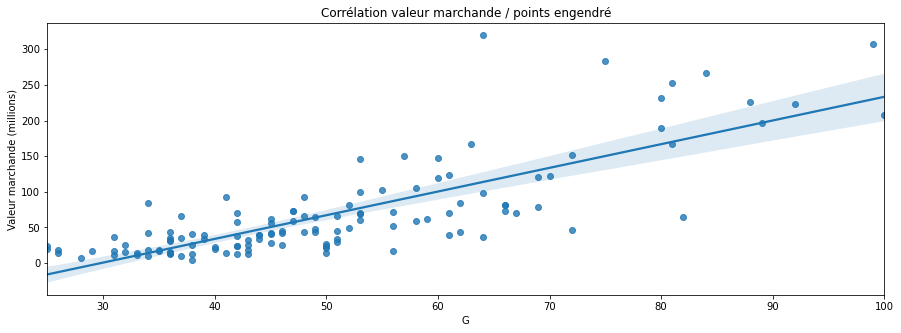

Covariance empirique :  865.3273431594857
Coefficient de Pearson :  0.8008890987918926

Les valeurs suivent une distribution linéaire


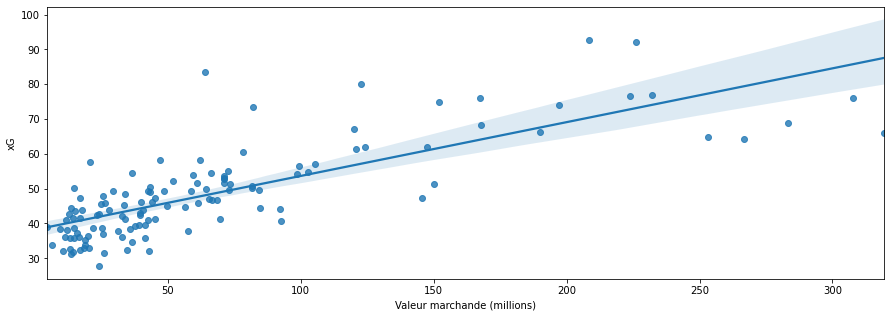

Covariance empirique :  692.6945504346181
Coefficient de Pearson :  0.7805695849240708

Les valeurs suivent une distribution linéaire


In [55]:
# buts marqués
plt.figure(figsize=[15,5])
sns.regplot(x='G',y='Valeur marchande (millions)',data=df_lig_val[df_lig_val['Positions'] == 'Attaquant'])
plt.title('Corrélation valeur marchande / points engendré')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Attaquant']["G"],df_lig_val[df_lig_val['Positions'] == 'Attaquant']["Valeur marchande (millions)"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xG',data=df_lig_val[df_lig_val['Positions'] == 'Attaquant'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Attaquant']['Valeur marchande (millions)'],df_lig_val[df_lig_val['Positions'] == 'Attaquant']['xG'])


In [56]:
df_lig_val[df_lig_val['Positions'] == 'Gardien']

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
0,1,Bayern Munich,34,25,4,5,80,18,79,66.21,21.94,73.61,2014,1.212,0.857,1.082,Gardien,26.20,49.75,9.950
5,2,Wolfsburg,34,20,9,5,72,38,69,58.35,38.82,59.95,2014,1.241,1.000,1.169,Gardien,26.00,6.65,2.220
10,3,Borussia M.Gladbach,34,19,9,6,53,26,66,51.74,36.34,57.01,2014,1.039,0.722,1.158,Gardien,26.67,10.45,3.480
15,4,Bayer Leverkusen,34,17,10,7,62,37,61,49.16,34.72,55.34,2014,1.265,1.088,1.109,Gardien,28.00,16.65,5.550
20,5,Augsburg,34,15,4,15,43,43,49,43.91,46.66,45.50,2014,1.000,0.935,1.089,Gardien,28.33,2.90,0.967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,14,Hertha Berlin,34,8,11,15,41,52,35,40.71,46.69,43.21,2020,1.025,1.130,0.814,Gardien,26.25,5.98,1.490
610,15,Arminia Bielefeld,34,9,8,17,26,52,35,31.14,58.98,30.08,2020,0.839,0.897,1.167,Gardien,22.50,6.70,1.680
615,16,FC Cologne,34,8,9,17,34,60,33,39.64,53.18,37.71,2020,0.872,1.132,0.892,Gardien,26.00,5.20,1.730
620,17,Werder Bremen,34,7,10,17,36,57,31,32.51,53.70,33.75,2020,1.125,1.075,0.939,Gardien,23.80,7.65,1.530


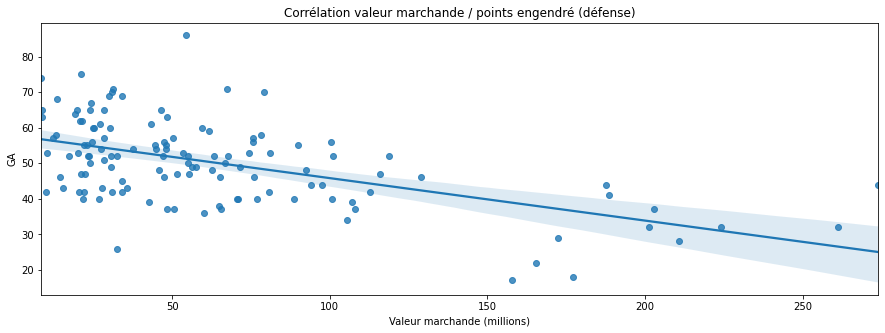

Covariance empirique :  -346.3172864701434
Coefficient de Pearson :  -0.5434843226079625

Les valeurs suivent une distribution linéaire


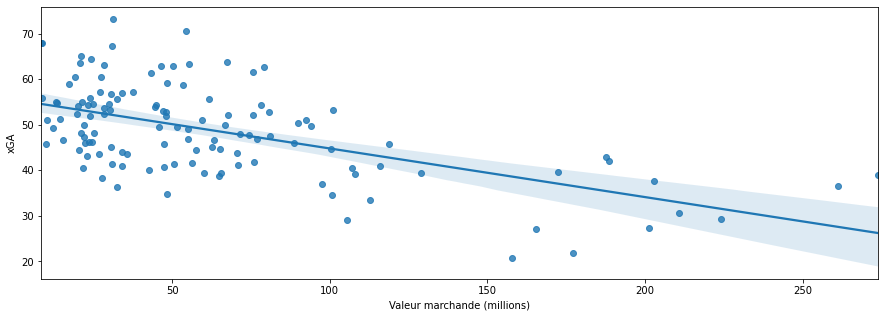

Covariance empirique :  -309.17375325018895
Coefficient de Pearson :  -0.5756879763982361

Les valeurs suivent une distribution linéaire


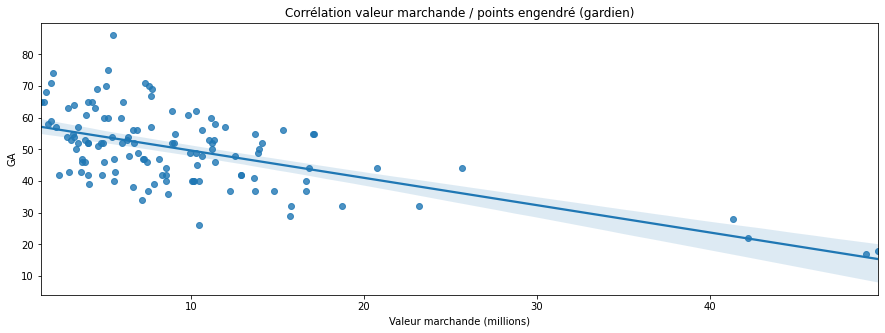

Covariance empirique :  -56.8363681027967
Coefficient de Pearson :  -0.5909319543730127

Les valeurs suivent une distribution linéaire


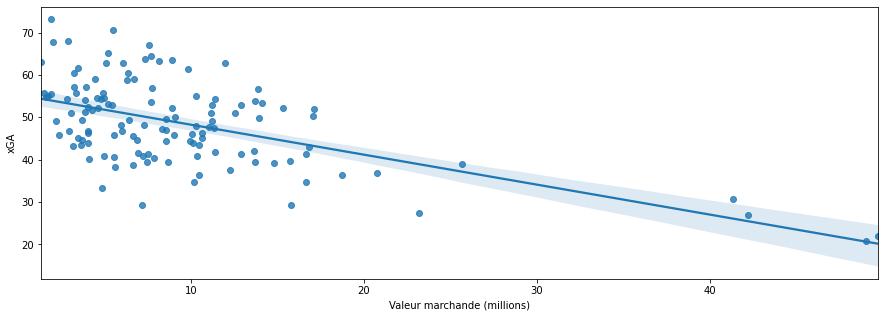

Covariance empirique :  -46.626323318216166
Coefficient de Pearson :  -0.5751935631895763

Les valeurs suivent une distribution linéaire


In [57]:
# buts encaissé
#défense
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='GA',data=df_lig_val[df_lig_val['Positions'] == 'Défense'])
plt.title('Corrélation valeur marchande / points engendré (défense)')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Défense']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Défense']["GA"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xGA',data=df_lig_val[df_lig_val['Positions'] == 'Défense'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Défense']['xGA'],df_lig_val[df_lig_val['Positions'] == 'Défense']['Valeur marchande (millions)'])
#gardien
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='GA',data=df_lig_val[df_lig_val['Positions'] == 'Gardien'])
plt.title('Corrélation valeur marchande / points engendré (gardien)')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Gardien']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Gardien']["GA"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xGA',data=df_lig_val[df_lig_val['Positions'] == 'Gardien'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Gardien']['xGA'],df_lig_val[df_lig_val['Positions'] == 'Gardien']['Valeur marchande (millions)'])


In [60]:
df_lig_val['win_rate'] = np.around(df_lig_val['W']/df_lig_val['M'],decimals=3)

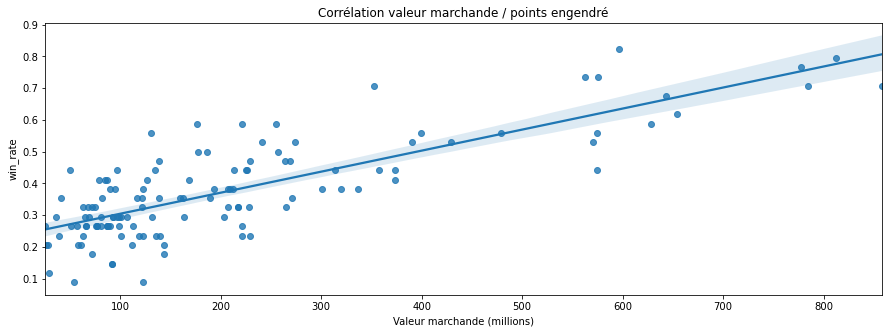

Covariance empirique :  22.290264687578734
Coefficient de Pearson :  0.7995141433890662

Les valeurs suivent une distribution linéaire


In [61]:
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='win_rate',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.title('Corrélation valeur marchande / points engendré')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Total']["win_rate"])

In [62]:
df_lig_val['Years'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [63]:
# df_lig_val[(df_lig_val['Team'] == 'Caen')]

In [68]:
df_value_pond_bef = []
for i in list(df_lig_val['Team'].unique()):
    for a in list(df_lig_val['Years'].unique()):
        try:
            gardien = 0.5*int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Gardien')]['Valeur marchande (millions)'])
            defense = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Défense')]['Valeur marchande (millions)'])
            milieu = 0.5*int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Milieu de terrain')]['Valeur marchande (millions)'])
            attaque = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Attaquant')]['Valeur marchande (millions)'])
            total = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['Valeur marchande (millions)'])
            rank = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['Rank']
            pts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['PTS']
            buts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['G']
            buts_enc = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['GA']
            xbuts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['xG']
            xbuts_enc = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['xGA']
            win_rate = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['win_rate']

            df_value_pond_bef.append(pd.DataFrame({'Rank':rank,'Team':i,'Years':a,'PTS':pts,'win_rate':win_rate,'G':buts,'GA':buts_enc,'xG':xbuts,'xGA':xbuts_enc,'Value totale':total,'Value attaque': np.around((attaque+milieu*0.25)/1.25,decimals=3),'Value défense': np.around((gardien*0.5+defense*1.25+milieu*0.25)/2,decimals=3)}))
        except TypeError:
            continue

In [69]:
value_pond_bef = pd.concat(df_value_pond_bef)

In [70]:
value_pond_bef.to_csv('pond_value_Bun.csv', index=False)

### Corrélation valeurs marchande pondérée / buts marqués - encaissés

In [67]:
value_pond = pd.read_csv('pond_value_Bun.csv',sep=',')

In [72]:
value_pond[value_pond['Years'] == 2014]

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense
0,1,Bayern Munich,2014,79,0.735,80,18,66.21,21.94,575,167.8,126.625
7,2,Wolfsburg,2014,69,0.588,72,38,58.35,38.82,221,47.8,47.125
14,3,Borussia M.Gladbach,2014,66,0.559,53,26,51.74,36.34,130,51.4,22.875
21,4,Bayer Leverkusen,2014,61,0.500,62,37,49.16,34.72,177,41.2,36.250
28,5,Augsburg,2014,49,0.441,43,43,43.91,46.66,50,14.9,10.438
35,6,Schalke 04,2014,48,0.382,42,40,41.26,46.96,211,60.8,52.625
42,7,Borussia Dortmund,2014,46,0.382,47,42,53.86,33.40,319,61.4,79.375
49,8,Hoffenheim,2014,44,0.353,49,55,49.96,50.00,121,53.8,15.875
56,9,Eintracht Frankfurt,2014,43,0.324,56,62,47.37,55.04,74,16.1,15.938
63,10,Werder Bremen,2014,43,0.324,50,65,42.67,52.38,67,21.1,13.562


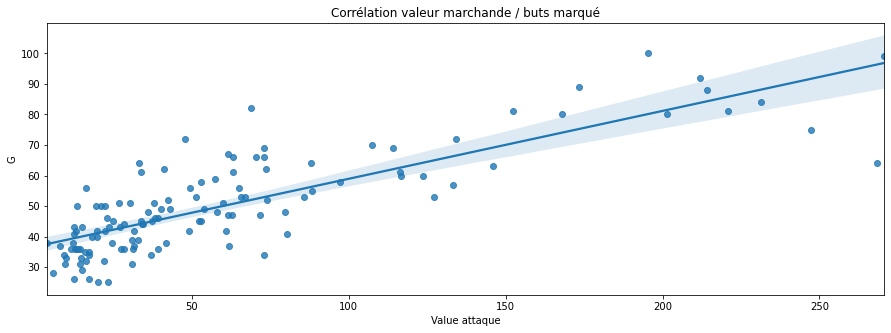

Covariance empirique :  778.9439153439151
Coefficient de Pearson :  0.8151533435730889

Les valeurs suivent une distribution linéaire


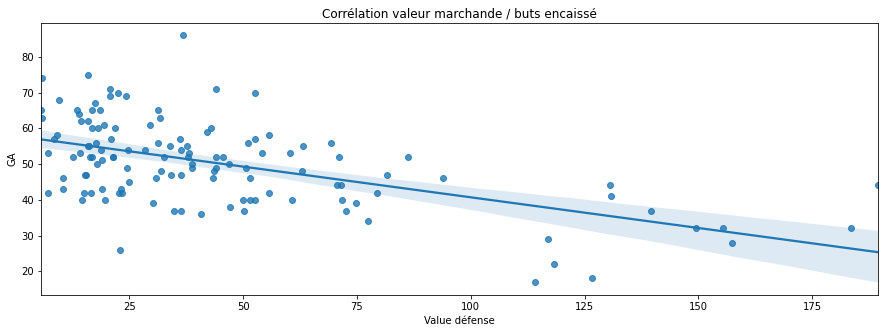

Covariance empirique :  -248.8794361300074
Coefficient de Pearson :  -0.5519613738932203

Les valeurs suivent une distribution linéaire


In [74]:
# buts marqué
#défense
plt.figure(figsize=[15,5])
sns.regplot(x="Value attaque",y='G',data=value_pond)
plt.title('Corrélation valeur marchande / buts marqué')
plt.show()
corré_quant(value_pond["Value attaque"],value_pond["G"])
plt.figure(figsize=[15,5])
sns.regplot(x='Value défense',y='GA',data=value_pond)
plt.title('Corrélation valeur marchande / buts encaissé')
plt.show()
corré_quant(value_pond['Value défense'],value_pond['GA'])

In [77]:
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = ['https://sofifa.com/players?type=all&lg%5B0%5D=19&hl=fr-FR&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&r=140052&set=true&offset=',
        'https://sofifa.com/players?type=all&lg%5B0%5D=19&hl=fr-FR&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&r=150059&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=19&hl=fr-FR&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&r=160058&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=19&hl=fr-FR&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&r=170099&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=19&hl=fr-FR&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&r=180084&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=19&hl=fr-FR&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&r=190075&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=19&hl=fr-FR&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&r=200061&set=true&offset=']

In [78]:
b = 0
list_error_name = [' L. Messi',' L. Messi',' L. Messi',' Cristiano Ronaldo',' L. Messi',' L. Messi',' L. Messi']
list_page_glob = []
x = 2014
for i in page:
    y = 0
    list_page = []
    while str(requests.get("{}{}".format(str(i),str(y)), headers=headers)) == '<Response [200]>':
        print(x,y)
        #print("{}{}".format(str(i),str(y)),"{}{}".format(str(i),str(y))=='https://sofifa.com/players')
        pageTree = requests.get("{}{}".format(str(i),str(y)), headers=headers)
        soup = BeautifulSoup(pageTree.content, 'html.parser')
        name = str(soup.body.find('div',{'class':'column col-auto'}).table.tbody.find_all('tr')[0].find('td',{"class":'col-name'}).find('div',{'class':'bp3-text-overflow-ellipsis'}).text)
        #print("{}{}".format(str(i),str(y)),name,b)
        if str(name) == list_error_name[b]:
            b = b + 1
            break
        else:
            list_name = []
            list_name.append(name)
            print(list_name)
            list_page.append("{}{}".format(str(i),str(y)))
            y = y +60
    x = x +1
    list_page_glob.append(list_page)

2014 0
[' F. Ribéry']
2014 60
[' M. Schmelzer']
2014 120
[' S. Jung']
2014 180
[' M. Feulner']
2014 240
[' J. Callsen-Bracker']
2014 300
[' Marcelo']
2014 360
[' J. Brandt']
2014 420
[' P. Slišković']
2014 480
[' G. Korte']
2014 540
[' B. Later']
2014 600
2015 0
[' M. Neuer']
2015 60
[' L. Stindl']
2015 120
[' T. Kraft']
2015 180
[' A. Rüdiger']
2015 240
[' J. Briand']
2015 300
[' Z. Stieber']
2015 360
[' D. Kohr']
2015 420
[' S. Kurt']
2015 480
[' L. Fröde']
2015 540
2016 0
[' M. Neuer']
2016 60
[' I. Traoré']
2016 120
[' S. Langkamp']
2016 180
[' Y. Gerhardt']
2016 240
[' E. Prib']
2016 300
[' R. Özcan']
2016 360
[' S. Parker']
2016 420
[' M. Schulz']
2016 480
[' M. Pantović']
2016 540
[' E. Balayev']
2016 600
2017 0
[' M. Neuer']
2017 60
[' R. Adler']
2017 120
[' A. Meier']
2017 180
[' L. Bailey']
2017 240
[' Caiuby']
2017 300
[' D. Kaiser']
2017 360
[' S. Schipplock']
2017 420
[' M. Zetterer']
2017 480
[' B. Sezer']
2017 540
[' M. Nicolas']
2017 600
2018 0
[' M. Neuer']
2018 60
[' 

In [79]:


df_fifa = []
x = 2014

for k in list_page_glob:
    #print(k)
    for e in k:
        pageTree = requests.get(e, headers=headers)
        soup = BeautifulSoup(pageTree.content, 'html.parser')
        
        value = soup.body.find('div',{'class':'column col-auto'}).table.tbody.find_all('tr')
        #print(value)
        for i in value:
            
            name = i.find('td',{"class":'col-name'}).find('div',{'class':'bp3-text-overflow-ellipsis'}).text
            age = i.find('td',{'class':'col col-ae'}).text
            club = i.find_all('td',{'class':'col-name'})[1].find('div',{'class':'bp3-text-overflow-ellipsis'}).a.text
#             print(i)
            poste = i.find('td',{'class':'col col-bp'}).text
            poid = i.find('td',{'class':'col col-hi'}).text
            accele = int(i.find('td',{'class':'col col-sp'}).span.text)
            speed = int(i.find('td',{'class':'col col-ac'}).span.text)
            offensif = int(i.find('td',{'class':'col col-ta'}).span.text)
            tech = int(i.find('td',{'class':'col col-ts'}).span.text)
            mouv = int(i.find('td',{'class':'col col-to'}).span.text)
            def_gene = int(i.find('td',{'class':'col col-td'}).span.text)
            gardien = int(i.find('td',{'class':'col col-tg'}).span.text)
            df_fifa.append(pd.DataFrame({'name':[name],'poste':[poste],'Team':[club],'taille':[poid],'accélération':[accele],'speed':[speed],'offensif':[offensif],'technique':[tech],'mouvement':[mouv],'defense general':[def_gene],'gardien general':[gardien],'Years':x}))

        #print(df_fifa)
    x = x + 1
#     print(x)
fifa_bef = pd.concat(df_fifa)

In [80]:
# for i in fifa[fifa['Years'] == 2020]['poid']:
#     print(i.split('"')[0])
#     dist = Distance(=i.split('"')[0].split("'")[0],inch=i.split('"')[0].split("'")[1])
#     print(dist.m)

In [81]:
fifa_bef

,name,poste,Team,taille,accélération,speed,offensif,technique,mouvement,defense general,gardien general,Years
0,F. Ribéry,AD,FC Bayern Munich,"5'7""",88,92,373,423,454,76,47,2014
0,A. Robben,MOC,FC Bayern Munich,"5'11""",91,93,381,424,454,78,49,2014
0,B. Schweinsteiger,MC,FC Bayern Munich,"6'0""",64,59,406,416,364,224,65,2014
0,M. Neuer,G,FC Bayern Munich,"6'4""",54,50,142,147,264,75,431,2014
0,P. Lahm,DLD,FC Bayern Munich,"5'7""",77,82,350,386,426,268,47,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
0,M. Beier,BU,TSG 1899 Hoffenheim,"6'0""",53,55,256,214,277,60,41,2020
0,M. Winter,MDC,RB Leipzig,"5'9""",50,55,236,262,280,173,53,2020
0,F. Ufuk,MDC,SC Paderborn 07,"5'9""",65,60,200,223,321,161,62,2020
0,J. Hupe,G,Borussia Dortmund,"6'7""",42,29,60,62,168,32,249,2020


In [82]:
fifa_bef.to_csv('fifa_glob_Bun.csv',index=False)

In [68]:
fifa = pd.read_csv('fifa_glob_Bun.csv',sep=',')

In [69]:
list_taille = []
for i in fifa['taille']:
    list_taille.append(np.around(int(i.split('"')[0].split("'")[0])*30.48 + int(i.split('"')[0].split("'")[1])*2.54,decimals=0))

In [70]:
fifa['taille'] = list_taille

In [71]:
moy_playeurs = fifa.groupby(['poste','Years']).mean().reset_index()

In [72]:
moy_playeurs

,poste,Years,taille,accélération,speed,offensif,technique,mouvement,defense general,gardien general
0,AD,2014,177.000000,78.926829,80.829268,317.585366,332.121951,383.975610,91.878049,50.097561
1,AD,2015,177.578947,79.210526,80.763158,320.000000,328.500000,385.500000,95.842105,49.263158
2,AD,2016,178.181818,77.181818,79.818182,316.454545,319.515152,375.757576,91.000000,54.363636
3,AD,2017,178.666667,82.000000,83.666667,323.500000,308.166667,390.500000,81.666667,53.500000
4,AD,2018,175.800000,89.800000,89.800000,322.600000,305.400000,416.800000,77.600000,56.600000
...,...,...,...,...,...,...,...,...,...,...
100,MOC,2016,177.866667,69.800000,73.244444,330.733333,368.533333,375.088889,111.355556,55.066667
101,MOC,2017,177.802469,70.777778,74.283951,317.098765,348.679012,368.827160,117.432099,53.074074
102,MOC,2018,178.278481,69.924051,73.329114,320.506329,350.164557,367.759494,119.202532,52.417722
103,MOC,2019,178.875000,67.517857,71.839286,322.821429,352.946429,363.607143,141.000000,52.196429


In [73]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    poste = ['BU','MOC', 'AG', 'AD','AT','MC']
    for e in poste:
        value = fifa[(fifa['Years'] == i)&(fifa['poste'] == e)]
        for q,k,a,j,l,g in zip_longest(value['Team'],value['accélération'],value['speed'],value['offensif'],value['technique'],value['mouvement']):
            #print(q,k,a,i,l,g)
            value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == e)]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
            accel = np.around(k/int(value_moy['accélération']),decimals=3)
            speedo = np.around(a/int(value_moy['speed']),decimals=3)
            offense = np.around(j/int(value_moy['offensif']),decimals=3)
            tech = np.around(l/int(value_moy['technique']),decimals=3)
            mouv = np.around(g/int(value_moy['mouvement']),decimals=3)
            df_off_coef.append(pd.DataFrame({'Team':[q],'poste':[e],'accélération':[accel], 'speed':[speedo], 'offensif':[offense],
       'technique':[tech], 'mouvement':[mouv], 'Years':[i]}))
off_coef = pd.concat(df_off_coef)

In [74]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    poste = ['DC', 'MDC', 'DLG','DG', 'DLD', 'DD']
    for e in poste:
        value = fifa[(fifa['Years'] == i)&(fifa['poste'] == e)]
        for q,k,a,j,l,g in zip_longest(value['Team'],value['taille'],value['accélération'],value['speed'],value['defense general'],value['gardien general']):
            #print(q,k,a,i,l,g)
            value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == e)]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
            accel = np.around(a/int(value_moy['accélération']),decimals=3)
            speedo = np.around(j/int(value_moy['speed']),decimals=3)
            tail = np.around(k/float(value_moy['taille']),decimals=3)
            def_gene = np.around(l/int(value_moy['defense general']),decimals=3)
            df_off_coef.append(pd.DataFrame({'Team':[q],'poste':[e], 'taille':[tail],'accélération':[accel], 'speed':[speedo],
       'defense generale':[def_gene], 'Years':[i]}))
def_coef = pd.concat(df_off_coef)

In [75]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    value = fifa[(fifa['Years'] == i)&(fifa['poste'] == 'G')]
    for q,k,a in zip_longest(value['Team'],value['taille'],value['gardien general']):
        value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == 'G')]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
        tail = np.around(k/float(value_moy['taille']),decimals=3)
        gard = np.around(a/int(value_moy['gardien general']),decimals=3)
        df_off_coef.append(pd.DataFrame({'Team':[q],'poste':'G', 'taille':[tail],'gardien generale':[gard], 'Years':[i]}))
gard_coef = pd.concat(df_off_coef)

In [76]:
gard_coef['coef'] = np.around((gard_coef['taille']+gard_coef['gardien generale']*1.5)/2.5,decimals=5)

In [77]:
def_coef['coef'] = np.around((def_coef['taille']+def_coef['accélération']+def_coef['speed']+def_coef['defense generale']*1.5)/4.5,decimals=5)

In [78]:
off_coef['coef'] = np.around((off_coef['offensif']*1.5+off_coef['accélération']+off_coef['speed']+off_coef['mouvement']+off_coef['technique'])/5.5,decimals=5)

In [79]:
def_coef = def_coef[['Team','poste','Years','coef']]

In [80]:
gard_coef = gard_coef[['Team','poste','Years','coef']]

In [81]:
off_coef = off_coef[['Team','poste','Years','coef']]

In [82]:
list_def_coef = []
def_coef[def_coef['poste'] == 'DC']['coef'] = def_coef[def_coef['poste'] == 'DC']['coef']*1.5
list_def_coef.append(def_coef[def_coef['poste'] == 'DC'])
list_def_coef.append(def_coef[def_coef['poste'] != 'DC'])
list_def_coef.append(gard_coef)
def_coef_glob = pd.concat(list_def_coef)

<ipython-input-82-03152599a842>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_coef[def_coef['poste'] == 'DC']['coef'] = def_coef[def_coef['poste'] == 'DC']['coef']*1.5


In [83]:
list_off_coef = []
off_coef[off_coef['poste'] == 'MC']['coef'] = off_coef[off_coef['poste'] == 'MC']['coef']*0.75
list_off_coef.append(off_coef[off_coef['poste'] == 'MC'])
list_off_coef.append(off_coef[off_coef['poste'] != 'MC'])
off_coef_glob = pd.concat(list_off_coef)

<ipython-input-83-f028df8da51d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_coef[off_coef['poste'] == 'MC']['coef'] = off_coef[off_coef['poste'] == 'MC']['coef']*0.75


In [84]:
off_coef_glob = off_coef_glob.groupby(['Team','Years']).mean().reset_index().sort_values(by='coef',ascending=False)

In [85]:
def_coef_glob = def_coef_glob.groupby(['Team','Years']).mean().reset_index().sort_values(by='coef',ascending=False)

In [86]:
df_coef = def_coef_glob.merge(off_coef_glob,how='inner',on=['Team','Years'])
df_coef.rename(columns={'coef_x':'coef défense','coef_y':'coef attaque'},inplace=True)

In [87]:
df_coef['Team'].unique()

array(['FC Bayern Munich', 'Bayer 04 Leverkusen', 'Borussia Dortmund',
       'Hambourg SV', 'Eintracht Francfort', 'VfL Wolfsbourg',
       '1. FSV Mayence 05', 'RB Leipzig', 'VfB Stuttgart',
       'FC Schalke 04', 'Hertha BSC', 'Borussia Mönchengladbach',
       'TSG 1899 Hoffenheim', 'SV Werder Brême', '1. FC Cologne',
       'Hanovre 96', 'FC Augsbourg', 'SC Fribourg', '1. FC Nuremberg',
       'Fortuna Düsseldorf', 'Eintracht Brunswick', 'FC Ingolstadt 04',
       'SV Darmstadt 98', 'SC Paderborn 07', '1. FC Union Berlin'],
      dtype=object)

In [88]:
def_coef[def_coef['Team'] == 'Eintracht Brunswick']['Years'].unique()

array([2014], dtype=int64)

In [89]:
'FC Augsbourg', 'SC Fribourg', '1. FC Nuremberg',
       'Fortuna Düsseldorf', 'Eintracht Brunswick', 'FC Ingolstadt 04',
       'SV Darmstadt 98', 'SC Paderborn 07', '1. FC Union Berlin'

IndentationError: unexpected indent (<ipython-input-89-7f439969c830>, line 2)

In [90]:
value_pond[value_pond['Years'] == 2014]

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense
0,1,Bayern Munich,2014,79,0.735,80,18,66.21,21.94,575,167.8,126.625
7,2,Wolfsburg,2014,69,0.588,72,38,58.35,38.82,221,47.8,47.125
14,3,Borussia M.Gladbach,2014,66,0.559,53,26,51.74,36.34,130,51.4,22.875
21,4,Bayer Leverkusen,2014,61,0.500,62,37,49.16,34.72,177,41.2,36.250
28,5,Augsburg,2014,49,0.441,43,43,43.91,46.66,50,14.9,10.438
35,6,Schalke 04,2014,48,0.382,42,40,41.26,46.96,211,60.8,52.625
42,7,Borussia Dortmund,2014,46,0.382,47,42,53.86,33.40,319,61.4,79.375
49,8,Hoffenheim,2014,44,0.353,49,55,49.96,50.00,121,53.8,15.875
56,9,Eintracht Frankfurt,2014,43,0.324,56,62,47.37,55.04,74,16.1,15.938
63,10,Werder Bremen,2014,43,0.324,50,65,42.67,52.38,67,21.1,13.562


In [95]:
df_coef['Team'] = [i.replace('FC Bayern Munich','Bayern Munich') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Bayer 04 Leverkusen','Bayer Leverkusen') for i in df_coef['Team']] 
value_pond['Team'] = [i.replace('Hamburger SV','Hambourg SV') for i in value_pond['Team']] 
df_coef['Team'] = [i.replace('Eintracht Francfort','Eintracht Frankfurt') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('VfL Wolfsbourg','Wolfsburg') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('1. FSV Mayence 05','Mainz 05') for i in df_coef['Team']]  
value_pond['Team'] = [i.replace('RasenBallsport Leipzig','RB Leipzig') for i in value_pond['Team']] 
df_coef['Team'] = [i.replace('FC Schalke 04','Schalke 04') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('Hertha BSC','Hertha Berlin') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('Borussia Mönchengladbach','Borussia M.Gladbach') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('SV Werder Brême','Werder Bremen') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('1. FC Cologne','FC Cologne') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('FC Augsbourg','Augsburg') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('SC Fribourg','Freiburg') for i in df_coef['Team']]
value_pond['Team'] = [i.replace('Nuernberg','1. FC Nuremberg') for i in value_pond['Team']]
value_pond['Team'] = [i.replace('Fortuna Duesseldorf','Fortuna Düsseldorf') for i in value_pond['Team']]
df_coef['Team'] = [i.replace('FC Ingolstadt 04','Ingolstadt') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('SV Darmstadt 98','Darmstadt') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('SC Paderborn 07','Paderborn') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('1. FC Union Berlin','Union Berlin') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('Hanovre 96','Hannover 96') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('TSG 1899 Hoffenheim','Hoffenheim') for i in df_coef['Team']]

In [96]:
for i,h in zip(df_coef['Team'].unique(),value_pond['Team'].unique()):
#     print(i,h)
    if (i not in df_coef['Team'].unique())|(i not in value_pond['Team'].unique()):
        print(i,'i')
    elif (h not in value_pond['Team'].unique())|(h not in df_coef['Team'].unique()):
        print(h,'k')

Eintracht Brunswick i
Arminia Bielefeld k


In [99]:
df_coef['Team'].unique()

array(['Bayern Munich', 'Bayer Leverkusen', 'Borussia Dortmund',
       'Hambourg SV', 'Eintracht Frankfurt', 'Wolfsburg', 'Mainz 05',
       'RB Leipzig', 'VfB Stuttgart', 'Schalke 04', 'Hertha Berlin',
       'Borussia M.Gladbach', 'Hoffenheim', 'Werder Bremen', 'FC Cologne',
       'Hannover 96', 'Augsburg', 'Freiburg', '1. FC Nuremberg',
       'Fortuna Düsseldorf', 'Eintracht Brunswick', 'Ingolstadt',
       'Darmstadt', 'Paderborn', 'Union Berlin'], dtype=object)

In [100]:
value_pond['Team'].unique()
# 'Arminia Bielefeld' 'Eintracht Brunswick'

array(['Bayern Munich', 'Wolfsburg', 'Borussia M.Gladbach',
       'Bayer Leverkusen', 'Augsburg', 'Schalke 04', 'Borussia Dortmund',
       'Hoffenheim', 'Eintracht Frankfurt', 'Werder Bremen', 'Mainz 05',
       'FC Cologne', 'Hannover 96', 'VfB Stuttgart', 'Hertha Berlin',
       'Hambourg SV', 'Freiburg', 'Paderborn', 'Ingolstadt', 'Darmstadt',
       'RB Leipzig', 'Fortuna Düsseldorf', '1. FC Nuremberg',
       'Union Berlin', 'Arminia Bielefeld'], dtype=object)

In [106]:
all_value_bef = value_pond.merge(df_coef,how='inner',on=['Team','Years'])

In [107]:
all_value_bef.to_csv('merge_value_Bun.csv',index=False)

In [108]:
all_value = pd.read_csv('merge_value_Bun.csv',sep=',')

In [109]:
list_euro = []
list_euro_detail = []
for i in all_value['Rank']:
    if i < 7:
        list_euro.append('Européen')
        if i < 5: 
            list_euro_detail.append('CL')
        else:
            list_euro_detail.append('EL')
    else:
        list_euro.append('Non-Européen')
        list_euro_detail.append('NE')
all_value['is_euro'] = list_euro
all_value['is_euro_detail'] = list_euro_detail

In [110]:
#méthode de calcul et d'affichage des cercles de corrélation et de l'ACP

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, pca, axis_ranks, labels=None, alpha=1):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    
    fig_1 = plt.figure(figsize=(8,7))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.savefig('Eboulis.png')
    plt.show(block=False)

In [111]:
all_value.columns

Index(['Rank', 'Team', 'Years', 'PTS', 'win_rate', 'G', 'GA', 'xG', 'xGA',
       'Value totale', 'Value attaque', 'Value défense', 'coef défense',
       'coef attaque', 'is_euro', 'is_euro_detail'],
      dtype='object')

In [112]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from sklearn import decomposition
from sklearn import preprocessing

data = all_value[['PTS', 'G', 'GA', 'Value totale',
       'Value attaque', 'Value défense', 'coef défense', 'coef attaque','win_rate']]
X = data.values

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = decomposition.PCA(n_components = 4)
pca.fit(X_scaled)

PCA(n_components=4)

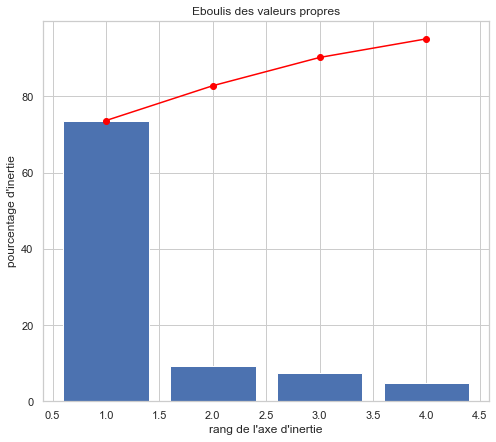

In [113]:
display_scree_plot(pca)

In [114]:
data.columns

Index(['PTS', 'G', 'GA', 'Value totale', 'Value attaque', 'Value défense',
       'coef défense', 'coef attaque', 'win_rate'],
      dtype='object')

v1 : PTS
v2 : Buts marqués
v3 : Buts encaissés
v4 : Value totale
v5 : Value attaque
v6 : Value défense
v7 : coef défense
v8 : coef attaque


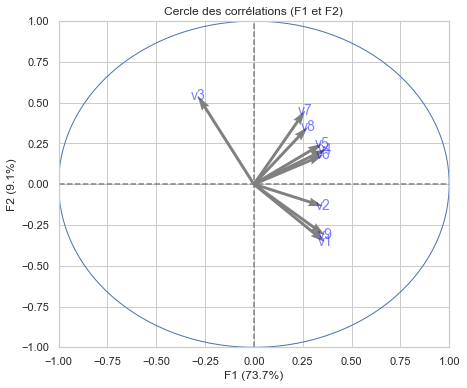

v3 est anti-corrélés aux variables PTS et coef attaque
v4,v5 et v6 ne sont corrélés à aucuns axes
v2,v7, v8 et v1 semblent être corrélés cependant les coefficients de corrélation sont plutôt faibles et traduisent une perte d'information
     
F1 : Capacité à faire avoir de bonnes performances / bon classement
     
F2 : incapacité à défendre
     


In [115]:
#ACP
features = data.columns
pcs = pca.components_
var = ['v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11']

print('v1 : PTS')
print('v2 : Buts marqués')
print('v3 : Buts encaissés')
print('v4 : Value totale')
print('v5 : Value attaque')
print('v6 : Value défense')
print('v7 : coef défense')
print('v8 : coef attaque')

#display_circles(pcs, 4, pca, [(0,1),(2,3),(4,5)],labels = np.array(features))
display_circles(pcs, 4, pca, [(0,1)],labels = np.array(var))

X_projected = pca.transform(X_scaled)
#display_factorial_planes(X_projected_2, 4, pca2, [(0,1),(2,3)], alpha = 0.2)

print('v3 est anti-corrélés aux variables PTS et coef attaque')
print('v4,v5 et v6 ne sont corrélés à aucuns axes')
print("v2,v7, v8 et v1 semblent être corrélés cependant les coefficients de corrélation sont plutôt faibles et traduisent une perte d'information")
print(' '*5)
print('F1 : Capacité à faire avoir de bonnes performances / bon classement')
print(' '*5)
print('F2 : incapacité à défendre')
print(' '*5)


plt.show()

In [116]:
f1 = []
f2 = []
for i in X_projected:
    f1.append(i[0])
    f2.append(i[1])
    
all_value['F1'] = f1
all_value['F2'] = f2

### La qualité de représentation des individus

In [117]:
data_compo = pd.DataFrame(X_projected,index=data.index,columns=["F"+str(i+1) for i in range(4)])
data_compo = data_compo.drop(['F3','F4'],axis=1)
data_compo

,F1,F2
0,5.328321,-1.458015
1,6.160240,-1.335290
2,5.817307,-0.791919
3,6.681528,-0.670979
4,6.162366,0.059961
...,...,...
106,3.292826,-0.883265
107,3.993231,-0.057680
108,3.981102,0.298043
109,-2.900776,0.668490


In [118]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = data_compo.values
#instanciation
sc = StandardScaler()
#transformation
Z = sc.fit_transform(X)

In [119]:
data_compo['is_euro'] = all_value['is_euro']
data_compo['is_euro_detail'] = all_value['is_euro_detail']

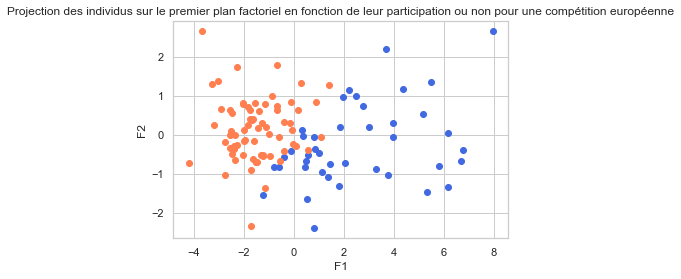

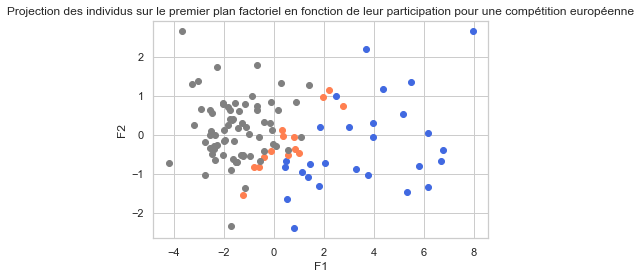

In [120]:
figsize = [15,7]
sns.set(style="whitegrid")
plt.scatter(data_compo[data_compo['is_euro'] == 'Européen']['F1'],data_compo[data_compo['is_euro'] == 'Européen']['F2'],c = 'royalblue')
plt.scatter(data_compo[data_compo['is_euro'] == 'Non-Européen']['F1'],data_compo[data_compo['is_euro'] == 'Non-Européen']['F2'],c = 'coral')
plt.title('Projection des individus sur le premier plan factoriel en fonction de leur participation ou non pour une compétition européenne')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()
figsize = [15,7]
sns.set(style="whitegrid")
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'CL']['F1'],data_compo[data_compo['is_euro_detail'] == 'CL']['F2'],c = 'royalblue')
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'EL']['F1'],data_compo[data_compo['is_euro_detail'] == 'EL']['F2'],c = 'coral')
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'NE']['F1'],data_compo[data_compo['is_euro_detail'] == 'NE']['F2'],c = 'grey')
plt.title('Projection des individus sur le premier plan factoriel en fonction de leur participation pour une compétition européenne')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()

In [121]:
acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z)

p = data_compo[['F1','F2']].shape[1]
di = np.sum(Z**2,axis=1)
contribu = pd.DataFrame({'d_i':di})
cos2 = coord**2
for j in range(p):
    cos2[:,j] = cos2[:,j]/di
data_cos = pd.DataFrame({'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]})

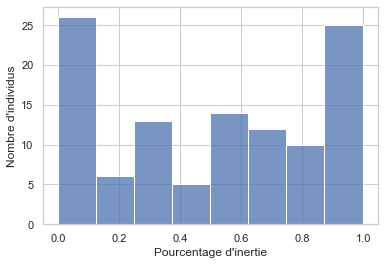

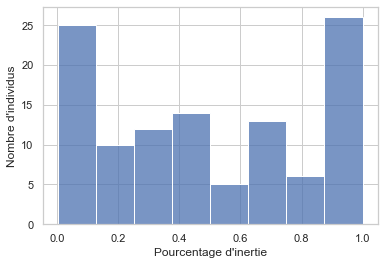

In [122]:
sns.histplot(x='COS2_1',data=data_cos)
plt.ylabel('Nombre d\'individus')
plt.xlabel('Pourcentage d\'inertie')
plt.show()
sns.histplot(x='COS2_2',data=data_cos)
plt.ylabel('Nombre d\'individus')
plt.xlabel('Pourcentage d\'inertie')
plt.show()

In [123]:
all_value

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
0,1,Bayern Munich,2014,79,0.735,80,18,66.21,21.94,575,167.8,126.625,1.020679,1.039301,Européen,CL,5.328321,-1.458015
1,1,Bayern Munich,2015,88,0.824,80,17,77.04,20.79,596,201.3,114.062,1.048340,1.033409,Européen,CL,6.160240,-1.335290
2,1,Bayern Munich,2016,82,0.735,89,22,73.91,27.04,562,173.4,118.250,1.054460,1.041910,Européen,CL,5.817307,-0.791919
3,1,Bayern Munich,2017,84,0.794,92,28,76.55,30.64,811,212.0,157.375,1.014797,1.058834,Européen,CL,6.681528,-0.670979
4,1,Bayern Munich,2018,78,0.706,88,32,92.24,27.41,784,214.2,149.375,1.030999,1.053098,Européen,CL,6.162366,0.059961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,3,RB Leipzig,2018,66,0.559,63,29,68.25,39.65,479,145.9,117.062,0.986548,1.054044,Européen,CL,3.292826,-0.883265
107,3,RB Leipzig,2019,66,0.529,81,37,76.13,37.58,570,152.4,139.500,1.009142,1.042158,Européen,CL,3.993231,-0.057680
108,2,RB Leipzig,2020,65,0.559,60,32,67.14,29.24,574,116.7,155.312,1.030344,1.054948,Européen,CL,3.981102,0.298043
109,17,Fortuna Düsseldorf,2019,30,0.176,36,67,35.69,64.45,71,13.6,17.375,0.973422,1.016255,Non-Européen,NE,-2.900776,0.668490


In [124]:
all_value[all_value['F2'] < -1]

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
0,1,Bayern Munich,2014,79,0.735,80,18,66.21,21.94,575,167.8,126.625,1.020679,1.039301,Européen,CL,5.328321,-1.458015
1,1,Bayern Munich,2015,88,0.824,80,17,77.04,20.79,596,201.3,114.062,1.048340,1.033409,Européen,CL,6.160240,-1.335290
7,2,Wolfsburg,2014,69,0.588,72,38,58.35,38.82,221,47.8,47.125,1.031914,1.003677,Européen,CL,1.825246,-1.313831
13,4,Wolfsburg,2020,61,0.500,61,37,51.59,39.16,256,63.1,72.562,1.000906,1.021430,Européen,CL,1.389099,-1.092851
14,3,Borussia M.Gladbach,2014,66,0.559,53,26,51.74,36.34,130,51.4,22.875,1.001508,0.998055,Européen,CL,0.813409,-2.403427
28,5,Augsburg,2014,49,0.441,43,43,43.91,46.66,50,14.9,10.438,0.996164,0.971545,Européen,EL,-1.250585,-1.538192
43,2,Borussia Dortmund,2015,78,0.706,82,34,83.41,29.18,352,68.8,77.500,1.034358,1.065264,Européen,CL,3.779195,-1.032915
51,4,Hoffenheim,2016,62,0.471,64,37,54.50,41.44,138,33.2,34.875,1.002571,1.003169,Européen,CL,0.546585,-1.653208
98,17,Freiburg,2014,34,0.206,36,47,38.69,45.91,57,12.6,15.250,0.969621,0.961729,Non-Européen,NE,-2.742721,-1.028704
101,8,Freiburg,2019,48,0.382,48,47,46.14,63.37,122,35.9,36.312,0.977956,0.965601,Non-Européen,NE,-1.150544,-1.362078


C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


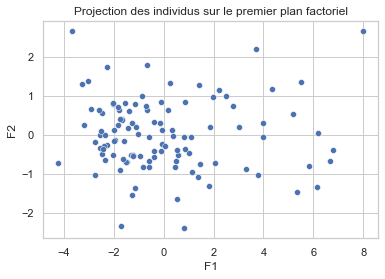

In [125]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F1'],all_value['F2'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection des individus sur le premier plan factoriel')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()

### Corrélation entre F1 et le classement du club correspondant ? 

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


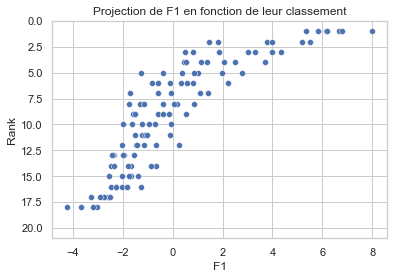

Covariance empirique :  -11.468391178746952
Coefficient de Pearson :  -0.8583148265636237

Les valeurs suivent une distribution linéaire


In [126]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F1'],all_value['Rank'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')
plt.savefig('project1.png')
plt.ylim(21,0)
plt.show()
corré_quant(all_value['F1'],all_value['Rank'])

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


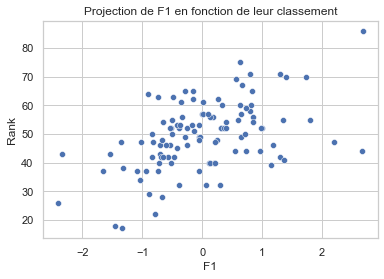

Covariance empirique :  1.482614783901809
Coefficient de Pearson :  0.31504449129942147

Les valeurs suivent une distribution linéaire


In [127]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F2'],all_value['GA'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')
plt.savefig('project1.png')
#plt.ylim(21,0)
plt.show()
corré_quant(all_value['F2'],all_value['Rank'])

In [128]:
all_value = all_value[(all_value['GA'] > 40)|(all_value['F2'] < 1)]

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Covariance empirique :  -11.50840170977775
Coefficient de Pearson :  -0.8578841421272293

Les valeurs suivent une distribution linéaire
Covariance empirique :  5.365389303795928
Coefficient de Pearson :  0.5059994584062115

Les valeurs suivent une distribution linéaire


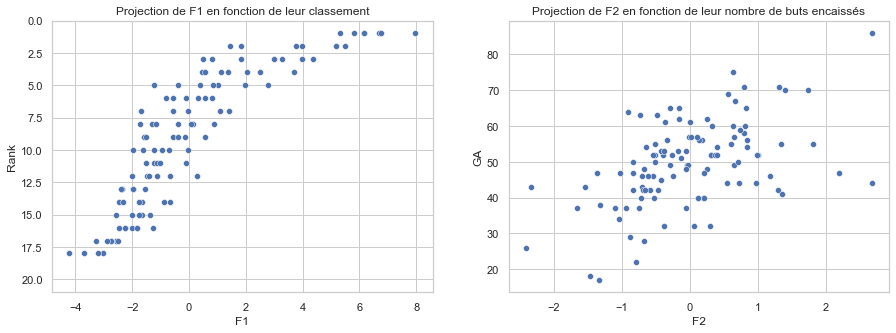

In [129]:
sns.set(style="whitegrid")
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.scatterplot(all_value['F1'],all_value['Rank'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')

plt.ylim(21,0)
corré_quant(all_value['F1'],all_value['Rank'])
corré_quant(all_value['F2'],all_value['GA'])
plt.subplot(122)
sns.scatterplot(all_value['F2'],all_value['GA'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F2 en fonction de leur nombre de buts encaissés')
plt.xlabel('F2')
plt.ylabel('GA')
#plt.ylim(21,0)
plt.show()

In [130]:
all_value[all_value['is_euro'] == 'Européen']

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
0,1,Bayern Munich,2014,79,0.735,80,18,66.21,21.94,575,167.8,126.625,1.020679,1.039301,Européen,CL,5.328321,-1.458015
1,1,Bayern Munich,2015,88,0.824,80,17,77.04,20.79,596,201.3,114.062,1.048340,1.033409,Européen,CL,6.160240,-1.335290
2,1,Bayern Munich,2016,82,0.735,89,22,73.91,27.04,562,173.4,118.250,1.054460,1.041910,Européen,CL,5.817307,-0.791919
3,1,Bayern Munich,2017,84,0.794,92,28,76.55,30.64,811,212.0,157.375,1.014797,1.058834,Européen,CL,6.681528,-0.670979
4,1,Bayern Munich,2018,78,0.706,88,32,92.24,27.41,784,214.2,149.375,1.030999,1.053098,Européen,CL,6.162366,0.059961
5,1,Bayern Munich,2019,82,0.765,100,32,92.85,36.47,777,195.3,183.438,1.008762,1.076175,Européen,CL,6.778573,-0.381073
6,1,Bayern Munich,2020,78,0.706,99,44,75.93,38.87,858,270.7,189.438,1.100580,1.090042,Européen,CL,7.975216,2.675349
7,2,Wolfsburg,2014,69,0.588,72,38,58.35,38.82,221,47.8,47.125,1.031914,1.003677,Européen,CL,1.825246,-1.313831
11,6,Wolfsburg,2018,55,0.471,62,50,49.49,49.84,229,73.6,46.875,1.004218,1.004285,Européen,EL,0.558069,-0.505323
13,4,Wolfsburg,2020,61,0.500,61,37,51.59,39.16,256,63.1,72.562,1.000906,1.021430,Européen,CL,1.389099,-1.092851


Covariance empirique :  458.3015289538997
Coefficient de Pearson :  0.944019223451245

Les valeurs suivent une distribution linéaire


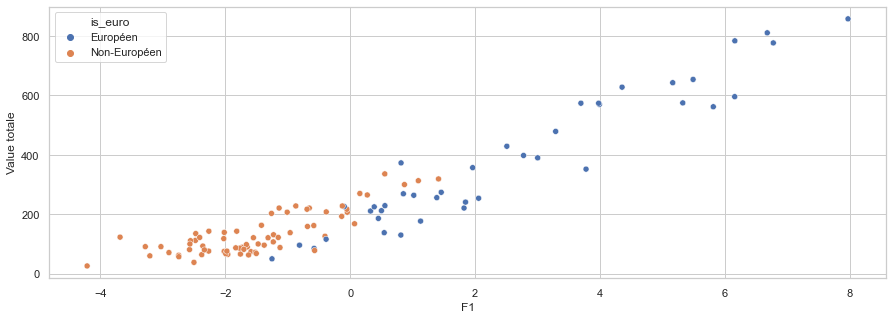

Covariance empirique :  23.717106384785023
Coefficient de Pearson :  0.5301698901575272

Les valeurs suivent une distribution linéaire


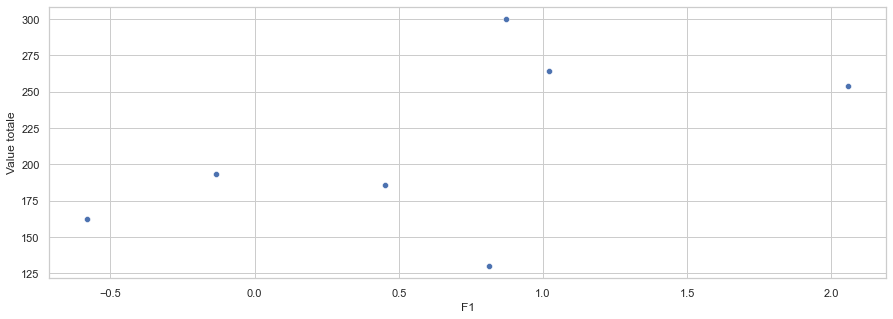

In [131]:
plt.figure(figsize=[15,5])
sns.scatterplot(x='F1',y='Value totale',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value['F1'],all_value['Value totale'])
plt.show()
plt.figure(figsize=[15,5])
sns.scatterplot(x='F1',y='Value totale',data=all_value[all_value['Team'] == 'Borussia M.Gladbach'])
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value[all_value['Team'] == 'Borussia M.Gladbach']['F1'],all_value[all_value['Team'] == 'Borussia M.Gladbach']['Value totale'])
plt.show()

In [132]:
all_value.head()

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
0,1,Bayern Munich,2014,79,0.735,80,18,66.21,21.94,575,167.8,126.625,1.020679,1.039301,Européen,CL,5.328321,-1.458015
1,1,Bayern Munich,2015,88,0.824,80,17,77.04,20.79,596,201.3,114.062,1.048340,1.033409,Européen,CL,6.160240,-1.335290
2,1,Bayern Munich,2016,82,0.735,89,22,73.91,27.04,562,173.4,118.250,1.054460,1.041910,Européen,CL,5.817307,-0.791919
3,1,Bayern Munich,2017,84,0.794,92,28,76.55,30.64,811,212.0,157.375,1.014797,1.058834,Européen,CL,6.681528,-0.670979
4,1,Bayern Munich,2018,78,0.706,88,32,92.24,27.41,784,214.2,149.375,1.030999,1.053098,Européen,CL,6.162366,0.059961


In [133]:
var_F2 = []
for i,a in zip(all_value['Value défense'],all_value['coef défense']):
    var_F2.append((a ** 3))
    print(i,'|',a,'|',(a ** 3))

126.625 | 1.0206785714285715 | 1.063327366460414
114.062 | 1.04834 | 1.1521432255657043
118.25 | 1.05446 | 1.1724391972565358
157.375 | 1.014797333333333 | 1.0450521232613283
149.375 | 1.0309993333333334 | 1.0959106650793748
183.438 | 1.0087620000000002 | 1.026516990613907
189.438 | 1.10058 | 1.3331065103151116
47.125 | 1.0319136842105263 | 1.098829005903738
44.125 | 1.02215 | 1.0679327347883747
37.938 | 1.0018777777777776 | 1.0056439181026182
31.875 | 0.99701 | 0.9910567935691008
46.875 | 1.0042182352941178 | 1.0127081614665507
51.562 | 1.00593 | 1.017895703227857
72.562 | 1.00090625 | 1.002721214611481
22.875 | 1.001507857142857 | 1.004530395756375
38.75 | 0.9988221428571428 | 0.9964705889796781
38.812 | 1.0069500000000002 | 1.0209952432023757
45.562 | 1.0090305555555557 | 1.0273370559178296
55.688 | 0.9980389473684208 | 0.99412837174586
60.812 | 1.01727 | 1.0527099095275827
69.188 | 1.0209526666666668 | 1.064184241240376
36.25 | 1.0188924999999998 | 1.0577550229037131
51.5 | 1.04684

Covariance empirique :  458.3015289538997
Coefficient de Pearson :  0.944019223451245

Les valeurs suivent une distribution linéaire


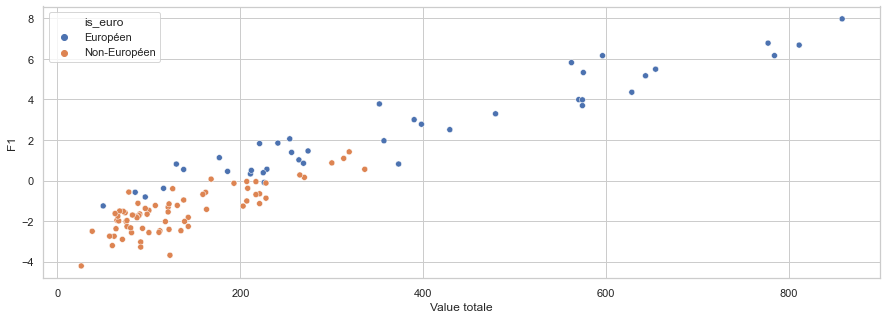

Covariance empirique :  -0.3611487956578383
Coefficient de Pearson :  -0.47883249492299174

Les valeurs suivent une distribution linéaire


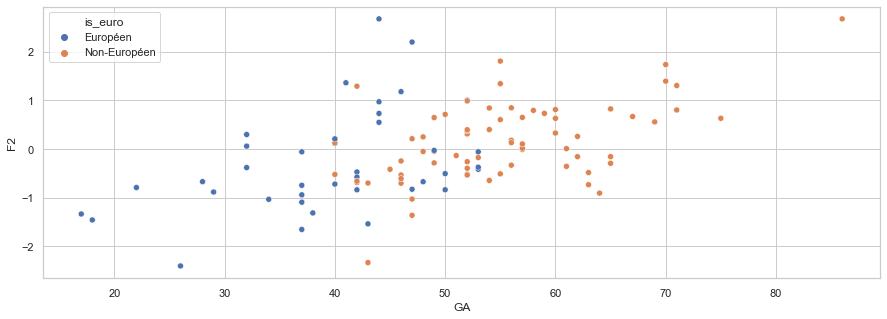

In [134]:
plt.figure(figsize=[15,5])
sns.scatterplot(x='Value totale',y='F1',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value['Value totale'],all_value['F1'])
plt.show()
plt.figure(figsize=[15,5])
sns.scatterplot(x='GA',y='F2',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(var_F2,all_value['xGA'])
plt.show()

In [137]:
# Déterminer la fonction de la trend
x = all_value['Value totale']
y_F1= all_value['F1']
y_F2= all_value['F2']
z_F1 = np.polyfit(x,y_F1,1)
z_F2 = np.polyfit(x,y_F2,1)
print ("{0}x + {1}".format(*z_F1))
print ("{0}x + {1}".format(*z_F2))
y_list_F1 = []
y_list_F2 = []
for i in x:
    y_list_F1.append(0.012921312294796969*i + -2.906403333514497)
    y_list_F2.append(0.0008951138984607017*i + -0.21032245711168626)

0.012921312294796969x + -2.906403333514497
0.0008951138984607017x + -0.21032245711168626


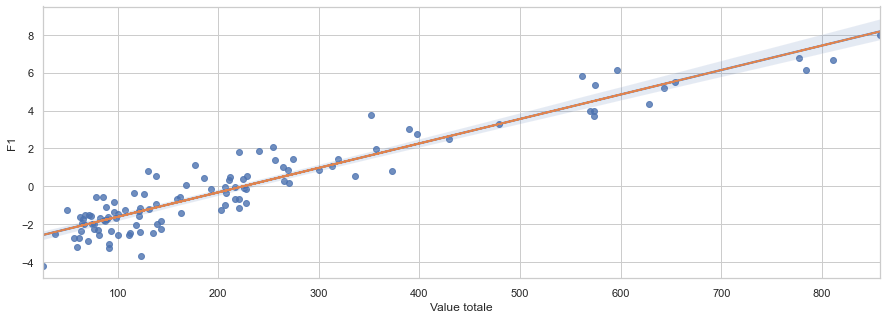

In [138]:
plt.figure(figsize=[15,5])
sns.regplot(x='Value totale',y='F1',data=all_value)
plt.plot(all_value['Value totale'],y_list_F1)
# corré_quant(all_value['Value totale'],all_value['F1'])
plt.show()

La fonction que nous avons obtenue est correcte puisque la trend du regplot et la fonction se superposent

In [139]:
all_value['trend'] = y_list_F1

<ipython-input-139-5d1da9557422>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_value['trend'] = y_list_F1


In [140]:
all_value[all_value['Team'] == 'Borussia M.Gladbach']

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2,trend
14,3,Borussia M.Gladbach,2014,66,0.559,53,26,51.74,36.34,130,51.4,22.875,1.001508,0.998055,Européen,CL,0.813409,-2.403427,-1.226633
15,4,Borussia M.Gladbach,2015,55,0.500,67,50,53.67,49.07,186,61.6,38.750,0.998822,1.004782,Européen,CL,0.453205,-0.837140,-0.503039
16,9,Borussia M.Gladbach,2016,45,0.353,45,49,45.82,44.44,162,52.1,38.812,1.006950,1.007949,Non-Européen,NE,-0.580721,-0.046829,-0.813151
17,9,Borussia M.Gladbach,2017,47,0.382,47,52,51.25,52.09,193,62.7,45.562,1.009031,1.028554,Non-Européen,NE,-0.133899,0.311906,-0.412590
18,5,Borussia M.Gladbach,2018,55,0.471,55,42,54.93,52.87,264,88.3,55.688,0.998039,1.038136,Européen,EL,1.020413,-0.471694,0.504823
19,4,Borussia M.Gladbach,2019,65,0.588,66,40,73.58,46.05,254,72.9,60.812,1.017270,1.048835,Européen,CL,2.058532,-0.720521,0.375610
20,8,Borussia M.Gladbach,2020,49,0.382,64,56,54.11,44.71,300,87.9,69.188,1.020953,1.026719,Non-Européen,NE,0.870660,0.847262,0.969990


In [141]:
# plt.figure(figsize=[20,5])
# plt.subplot(121)
# list_trend = list(abs(all_value[all_value['Team'] == 'Arsenal']['trend']*10))
# list_value = list(abs(all_value[all_value['Team'] == 'Arsenal']['Value totale']/10))
# sns.lineplot(x='Years',y='Rank',data=all_value[all_value['Team'] == 'Arsenal'],label='Rank')
# sns.lineplot(x='Years',y=list_trend,data=all_value[all_value['Team'] == 'Arsenal'],label='trend')
# # sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
# plt.ylim(21,0)
# plt.subplot(122)

# sns.lineplot(x='Years',y='Value totale',data=all_value[all_value['Team'] == 'Arsenal'],label='Valeur totale')
# plt.show()

A partir des corrélations, on va va prévoir se baser sur 3 variables pour prévoir le futur classement du mhsc :
* Classement
* F1
* Valeur de l'effectif

In [142]:
all_value.columns

Index(['Rank', 'Team', 'Years', 'PTS', 'win_rate', 'G', 'GA', 'xG', 'xGA',
       'Value totale', 'Value attaque', 'Value défense', 'coef défense',
       'coef attaque', 'is_euro', 'is_euro_detail', 'F1', 'F2', 'trend'],
      dtype='object')

In [143]:
variables = all_value[['Team','Rank','F1','Value totale','Years','is_euro','is_euro_detail','trend', 'win_rate']]

<AxesSubplot:>

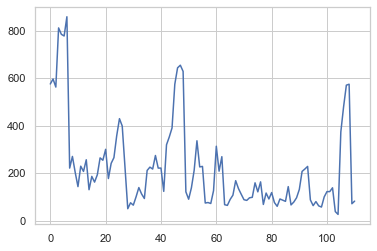

In [144]:
variables['Value totale'].plot()

In [145]:
list_value = []
for i in variables['Value totale']:
    if i < 90:
        list_value.append('> 90 m')
    elif (i >= 90)&(i < 150): 
        list_value.append('90 m < i < 150 m')
    elif (i >= 150)&(i < 250): 
        list_value.append('150 m < i < 250 m')
    elif (i >= 250)&(i < 350): 
        list_value.append('250 m < i < 350 m')
    elif (i >= 350)&(i < 500): 
        list_value.append('350 m < i < 500 m')
    elif i >= 500: 
        list_value.append('> 500 m')
variables['ech_value'] = list_value

<ipython-input-145-6511d62279f7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['ech_value'] = list_value


In [146]:
pal = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)

In [147]:
# euro_var
[['> 90 m','90 m < i < 150 m','150 m < i < 250 m','250 m < i < 350 m','350 m < i < 500 m','> 500 m']]

[['> 90 m',
  '90 m < i < 150 m',
  '150 m < i < 250 m',
  '250 m < i < 350 m',
  '350 m < i < 500 m',
  '> 500 m']]

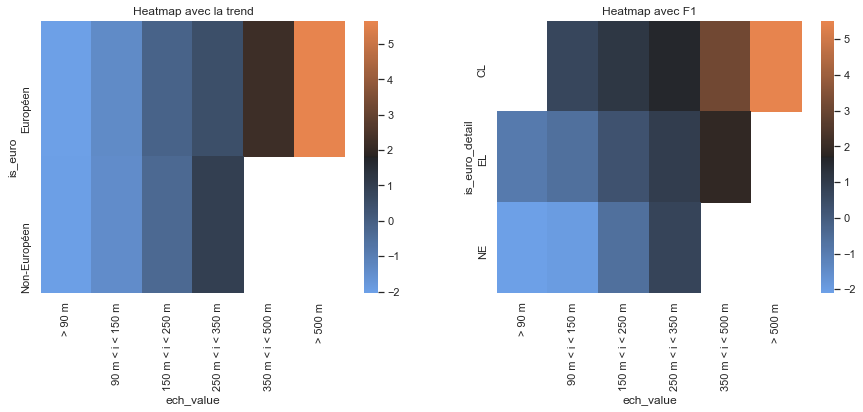

In [148]:
euro_var = variables.groupby(['is_euro','ech_value']).mean().reset_index()[['is_euro','ech_value','trend']].pivot(index='is_euro',columns='ech_value',values='trend')[['> 90 m','90 m < i < 150 m','150 m < i < 250 m','250 m < i < 350 m','350 m < i < 500 m','> 500 m']]
euro_detail_var = variables.groupby(['is_euro_detail','ech_value']).mean().reset_index()[['is_euro_detail','ech_value','trend']].pivot(index='is_euro_detail',columns='ech_value',values='trend')[['> 90 m','90 m < i < 150 m','150 m < i < 250 m','250 m < i < 350 m','350 m < i < 500 m','> 500 m']]
euro_var_F1 = variables.groupby(['is_euro','ech_value']).mean().reset_index()[['is_euro','ech_value','F1']].pivot(index='is_euro',columns='ech_value',values='F1')[['> 90 m','90 m < i < 150 m','150 m < i < 250 m','250 m < i < 350 m','350 m < i < 500 m','> 500 m']]
euro_detail_var_F1 = variables.groupby(['is_euro_detail','ech_value']).mean().reset_index()[['is_euro_detail','ech_value','F1']].pivot(index='is_euro_detail',columns='ech_value',values='F1')[['> 90 m','90 m < i < 150 m','150 m < i < 250 m','250 m < i < 350 m','350 m < i < 500 m','> 500 m']]
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.heatmap(euro_var,cmap=pal)
plt.title('Heatmap avec la trend')
plt.subplot(122)
sns.heatmap(euro_detail_var_F1,cmap=pal)
plt.title('Heatmap avec F1')
plt.show()
# plt.figure(figsize=[15,5])
# plt.subplot(121)
# sns.heatmap(euro_detail_var,cmap=pal)
# plt.title('Heatmap avec la trend')
# plt.subplot(122)
# sns.heatmap(euro_detail_var_F1,cmap=pal)
# plt.title('Heatmap avec F1')
# plt.show()

### Prédictions 

Régression logistique

K-Means

In [149]:
# <!-- * analyse de la variance -->

In [150]:
variables.head()

,Team,Rank,F1,Value totale,Years,is_euro,is_euro_detail,trend,win_rate,ech_value
0,Bayern Munich,1,5.328321,575,2014,Européen,CL,4.523351,0.735,> 500 m
1,Bayern Munich,1,6.160240,596,2015,Européen,CL,4.794699,0.824,> 500 m
2,Bayern Munich,1,5.817307,562,2016,Européen,CL,4.355374,0.735,> 500 m
3,Bayern Munich,1,6.681528,811,2017,Européen,CL,7.572781,0.794,> 500 m
4,Bayern Munich,1,6.162366,784,2018,Européen,CL,7.223906,0.706,> 500 m


#### K-Means 

C:\Users\gormt\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


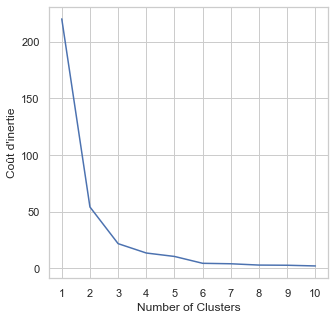

In [151]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import decomposition,preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid

data = variables[["trend","Value totale"]]
X = data.values
X_scaled = preprocessing.StandardScaler().fit_transform(X)

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    
fig_1 = plt.figure(figsize=(5,5))

#plt.style.use("fivethirtyeight")
sns.set(style="whitegrid")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Coût d'inertie")
plt.savefig('graph_cout_inert.png')
plt.show()

In [152]:
# Projection des individus
# Réduire  ici est nécessaire car les variables sont pas exprimées dans la même unité
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#X_projected = pca.transform(X_scaled)

# Clustering par K-means
# 2 clusters
km = KMeans(n_clusters=2)
km.fit(X_scaled)
y_means = km.predict(X_scaled)

km3 = KMeans(n_clusters=3)
km3.fit(X_scaled)
y_means3 = km3.predict(X_scaled)

clust_lab3 = km3.labels_

ValueError: 'c' argument has 110 elements, which is inconsistent with 'x' and 'y' with size 111.

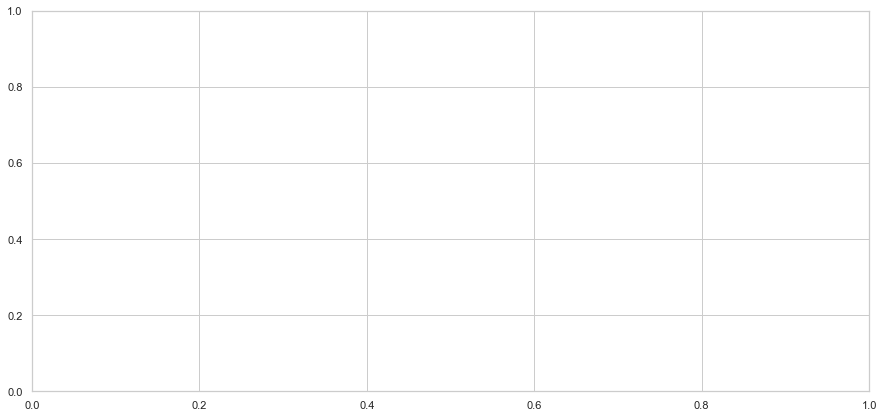

In [153]:
import matplotlib.patches as mpatches
# Visualisation de nos deux clusters dans le premier plan factoriel

plt.figure(figsize=(15, 7))

categories = km.labels_
colormap = np.array(['royalblue','coral'])
sns.set(style="whitegrid")
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[categories], 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

lab_0 = mpatches.Patch(color='royalblue', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='coral', alpha=0.5, label='1')
lab_2 = mpatches.Patch(color='grey', alpha=0.5, label='1')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)),fontsize='large')
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)),fontsize='large')
plt.title("Projection en 2 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.savefig('project_ind_kmeans.png')
plt.show()

plt.figure(figsize=(15, 7))
categories3 = km3.labels_
colormap = np.array(['royalblue','coral','grey'])
sns.set(style="whitegrid")
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[categories3], 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

lab_0 = mpatches.Patch(color='royalblue', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='coral', alpha=0.5, label='1')
lab_2 = mpatches.Patch(color='grey', alpha=0.5, label='2')
plt.legend(handles=[lab_0, lab_1, lab_2])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)),fontsize='large')
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)),fontsize='large')
plt.title("Projection en 3 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.savefig('project_ind_kmeans.png')
plt.show()

In [156]:
variables['clusters'] = categories
# variables['clusters_3'] = categories3

<ipython-input-156-10f62482c47d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['clusters'] = categories


In [157]:
variables

,Team,Rank,F1,Value totale,Years,is_euro,is_euro_detail,trend,win_rate,ech_value,clusters
0,Bayern Munich,1,5.328321,575,2014,Européen,CL,4.523351,0.735,> 500 m,1
1,Bayern Munich,1,6.160240,596,2015,Européen,CL,4.794699,0.824,> 500 m,1
2,Bayern Munich,1,5.817307,562,2016,Européen,CL,4.355374,0.735,> 500 m,1
3,Bayern Munich,1,6.681528,811,2017,Européen,CL,7.572781,0.794,> 500 m,1
4,Bayern Munich,1,6.162366,784,2018,Européen,CL,7.223906,0.706,> 500 m,1
...,...,...,...,...,...,...,...,...,...,...,...
106,RB Leipzig,3,3.292826,479,2018,Européen,CL,3.282905,0.559,350 m < i < 500 m,1
107,RB Leipzig,3,3.993231,570,2019,Européen,CL,4.458745,0.529,> 500 m,1
108,RB Leipzig,2,3.981102,574,2020,Européen,CL,4.510430,0.559,> 500 m,1
109,Fortuna Düsseldorf,17,-2.900776,71,2019,Non-Européen,NE,-1.988990,0.176,> 90 m,0


<AxesSubplot:xlabel='clusters', ylabel='is_euro'>

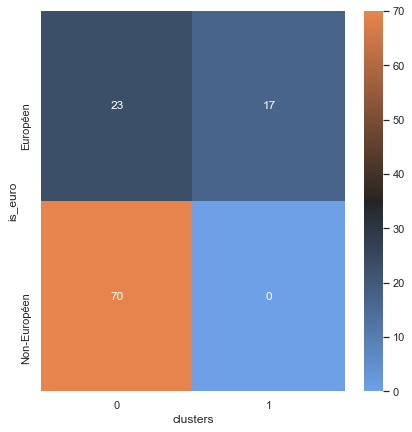

In [158]:
euro = pd.crosstab(variables['is_euro'], variables["clusters"],margins=True,margins_name='Total')
# euro_bis = pd.crosstab(variables['is_euro_detail'], variables["clusters_3"],margins=True,margins_name='Total')
plt.figure(figsize=(15, 7))
plt.subplot(121)
sns.heatmap(euro.iloc[0:2,0:-1],annot=True, cmap=pal)
# plt.subplot(122)
# sns.heatmap(euro_bis.iloc[0:3,0:-1],annot=True, cmap=pal)
# plt.show()

Résultat beaucoup trop approximatif pour le second K-Means

Cependant, on peut poursuivre l'analyse avec le premier K-Means dont les résultats sont pas si mauvais, seulement 5 faux-négatifs et faux-positifs

In [159]:
from sklearn.model_selection import train_test_split
variables_corr = variables[['Team','Rank','trend','Value totale','Years','is_euro','ech_value','clusters']]
list_euro = []
for i in variables_corr['is_euro']:
    if i == 'Européen':
        list_euro.append(1)
    elif i == 'Non-Européen':
        list_euro.append(0)
variables_corr['is_euro'] = list_euro 
xtrain, xtest, ytrain, ytest = train_test_split(variables_corr[['trend']], variables_corr[['is_euro']], train_size=0.8)

<ipython-input-159-358f60f612ea>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_corr['is_euro'] = list_euro


In [160]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import pickle

modele_logit = LogisticRegression()
modele_logit.fit(xtrain,ytrain)
precision = modele_logit.score(xtest,ytest)

with open('model_bun.pkl', 'wb') as f:
    my_pickler = pickle.Pickler(f)
    my_pickler.dump(modele_logit)

C:\Users\gormt\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


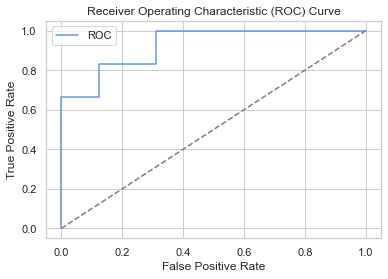

In [161]:
probs = modele_logit.predict_proba(xtest)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(ytest, probs) 
plot_roc_curve(fper, tper)

#### Matrice de confusion

In [162]:
variables_corr = variables_corr.reset_index()
ytest = ytest.reset_index()

In [163]:
variables_corr

,index,Team,Rank,trend,Value totale,Years,is_euro,ech_value,clusters
0,0,Bayern Munich,1,4.523351,575,2014,1,> 500 m,1
1,1,Bayern Munich,1,4.794699,596,2015,1,> 500 m,1
2,2,Bayern Munich,1,4.355374,562,2016,1,> 500 m,1
3,3,Bayern Munich,1,7.572781,811,2017,1,> 500 m,1
4,4,Bayern Munich,1,7.223906,784,2018,1,> 500 m,1
...,...,...,...,...,...,...,...,...,...
105,106,RB Leipzig,3,3.282905,479,2018,1,350 m < i < 500 m,1
106,107,RB Leipzig,3,4.458745,570,2019,1,> 500 m,1
107,108,RB Leipzig,2,4.510430,574,2020,1,> 500 m,1
108,109,Fortuna Düsseldorf,17,-1.988990,71,2019,0,> 90 m,0


In [164]:
data_predict = pd.merge(variables_corr,ytest,how = 'inner',on='index')
data_predict = data_predict.drop(['index'],axis=1)

In [165]:
data_predict

,Team,Rank,trend,Value totale,Years,is_euro_x,ech_value,clusters,is_euro_y
0,Bayern Munich,1,8.180083,858,2020,1,> 500 m,1,1
1,Wolfsburg,8,0.582351,270,2015,0,250 m < i < 350 m,0,0
2,Wolfsburg,7,-0.231692,207,2019,0,150 m < i < 250 m,0,0
3,Borussia M.Gladbach,8,0.969990,300,2020,0,250 m < i < 350 m,0,0
4,Augsburg,13,-2.066518,65,2016,0,> 90 m,0,0
5,Borussia Dortmund,3,2.132908,390,2016,1,350 m < i < 500 m,1,1
6,Borussia Dortmund,2,5.544135,654,2019,1,> 500 m,1,1
7,Hoffenheim,15,-1.743485,90,2015,0,90 m < i < 150 m,0,0
8,Hoffenheim,6,0.013813,226,2019,1,150 m < i < 250 m,0,1
9,Eintracht Frankfurt,16,-1.924384,76,2015,0,> 90 m,0,0


In [166]:
predict = pd.crosstab(data_predict['is_euro_x'], data_predict["is_euro_y"],rownames=['Actual'], colnames=['Predicted'],margins=True,margins_name='Total')

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

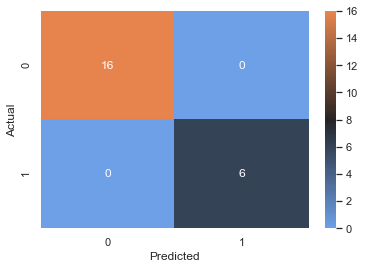

In [167]:
sns.heatmap(predict.iloc[0:2,0:-1],annot=True, cmap=pal)

In [168]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(' ')
print('Precision: %.3f' % precision_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('Recall: %.3f' % recall_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('Accuracy: %.3f' % accuracy_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('F1 Score: %.3f' % f1_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))

 
Precision: 1.000
Recall: 1.000
Accuracy: 1.000
F1 Score: 1.000


In [169]:
print(sklearn.metrics.classification_report(data_predict['is_euro_x'], data_predict["is_euro_y"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         6

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



In [170]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import Logit
mode = Logit(endog=ytrain,exog=xtrain)
lr = mode.fit()

lr.summary()

Optimization terminated successfully.
         Current function value: 0.426158
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_euro   No. Observations:                   88
Model:                          Logit   Df Residuals:                       87
Method:                           MLE   Df Model:                            0
Date:                Thu, 19 Aug 2021   Pseudo R-squ.:                  0.3612
Time:                        17:36:43   Log-Likelihood:                -37.502
converged:                       True   LL-Null:                       -58.704
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          1.1567      0.247      4.683      0.000       0.673       1.641
==============================================================================
"""